<font color = '#0051ba'>


<p align="center">
<img height="60" width="120" src="./Graphics/UR_Logo.jpg" > 

# Residential Real-Estate Spot-Market Pricing Model for Ames, IA.

</p>

</font>

<font color = '#003459'>

### Client:  SlumRock Partners, LLP
### Deliverable:  Interim Report
    
</font>

### Overview.

This logic provides Uncertainty Research client SlumRock Partners with a Spot-Market Pricing Model for residential real estate.  SlumRock initiated a fund to follow other hedge funds in to the residential real-estate rental market.  The business model is described in [R. Dizember, L. Kuzisto, *WSJ*, July 21, 20176](https://www.wsj.com/articles/meet-your-new-landlord-wall-street-1500647417) and [A. Semiuels, *The Atlantic*, February 13, 2019](https://www.theatlantic.com/technology/archive/2019/02/single-family-landlords-wall-street/582394/), among other places. 

This logic estimates housing-market spot prices using a subset of 216 available explanatory variables. The high-level workflow follows.

🅐 **Read in and cleanse data**.  We read in the data and address basic heigene issues. We also generate a data-dictionary template, which is exported to a csv file.  We further elaborate on data characteristics in that data dictionary.  

🅑 **Perform data preparation**.  The populated data dictionary is read in and employed by the logic to apply additional preparatory activities.  This includes decisions about which explanatory variables to discard up front, and how to handle null values.

🅒 **Influential-variable analysis**.  Ascertain which variables are most-likely influential for our response variable `SalePrice`.  We have three classes of variables.

⓵ <span style="text-decoration:underline">Continuous Numeric Variables</span>.  Straightforwardly, the degree of influence for continuous numeric variables is directly related to their colinearity — e.g,. correlation — with the response variable.  These variables are judged to be influential if the correlation $\rho_{x_{i,j}, y_i }\gtrapprox 0.45$.  This relatively low threshold offers a starting point, from which the initial model is likely overfit.

⓶ <span style="text-decoration:underline">Discrete Numeric Variables</span>.  We emply the same criteria for discrete explanatories as for continuous.  These variables are judged to be influential if the correlation $\rho_{x_{i,j}, y_i }\gtrapprox 0.45$.  

⓷ <span style="text-decoration:underline">Categorical Variables</span>.  A definition of colinearity between discrete and continuous variables does not exist.  We can however think about using the reciprocal problem as indicating extent of influence. That is, if our continouous response variable by itself predicts the categoricals, then the latter must be influential of the former.  So, we construct a univariate multinomial logistic model for each explanatory categorical to see how well the continouous response variable `SalePrice` predicts them. Categoricals are deemed influential if the score of the associated model $\gtrapprox 0.65$.


🅓 **Feature engineering.** We split the data into training and test steps. We then perform feature engineering.

⓵ We expand our categorical variables into dummy variables.

⓶ We expand our numeric — continouous and discrete — variables into second-order polynomials.

⓷ We then standardize the scale.

🅔 **Model Development**.  Our consideration here is limited to linear models.  We explore four variaants.

⓵ Ordinary Least Squares.  

⓶ Ridge regression.

⓷ Lasso regression.

⓸ ElasticNet regression.

In all cases we contribute basic analysis-of-variance (ANOVA) and related scoring, e.g., Coefficient of Determination $R^2$.  With the OLS, we also confidence intervals and significance tests (p-values).  We also look at response and residual plots [Olive, 2017, §2.1](https://www.springer.com/gp/book/9783319552507).  Adding Locally-Weigthed Scatter-plot Smoothing (LOWESS) [Olive, 2017, §2.2](https://www.springer.com/gp/book/9783319552507) gives us a sense of the model's bias.

🅕 **Model Iteration**. Based on ANOVA and -related scores, we select the Ridge-regression as the baeline approach.  Our model's residuals turn out to be outlier-dominated.  Our coefficients of variation for training and test are $R_\text{train}^2 \approx 0.88$ and $R_\text{test} \approx 0.81$, respectively.  The LOWESS curves deviate modestly from the ideal response and residual curves.

Our iteration focuses on these outliers.  We remove variables a few at at time — mostly interaction variables for which phenomenological justificaiton doesn't seem obvious.  We get to the point at which `GrLivArea`, above-grade living space, dominates.  

🅖 **Model Interpretation**. Once phenomenologically justifiable explanatory dominate our outliers' residuals, we turn to model interpretation.  Our model — except for a small number ($\lesssim 3-4$ ) outliers — explains the `SalePrice` response variable relatively well.  We look at the specific outliers. They are large-footprint (`GrLivArea`) properties in a `Neighborhood` `Edwards` for which prices are low for the market.  We do not have evidence to justify discarding these measurements.

Additionally, our model overestimates prices at the upper end of the market.  This is a limitation of linearity.




In [1]:
#Imports:
import pandas as pd
import numpy as np
from collections import Counter
import pandas as pd
import scipy.stats as stats
import os as os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import functools as fct
import seaborn as sns
import itertools as it
import scipy as sci
import math as mt
from pytablewriter import MarkdownTableWriter
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, ElasticNetCV, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from copy import deepcopy

from statsmodels.distributions.empirical_distribution import ECDF
import pandas_profiling as pdp
import io


from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor,\
                             BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

data_source_dir = '/Users/nhamlett/Documents/GitHub/GA-DSI/project/project_1/data'



In [2]:
#
# Partition a list into a specified number of bins.  Our inputs
# are:
# ⧐ parted_list is the list to be partitioned;
# ⧐ partition_counts specifies the number of bins into which
#   parted_list is divided.
# We produce an enumerated dictionary of the list partitions.
def partition_list(parted_list, partition_counts):
    parted_list = np.sort(np.array(parted_list))
    partition_len = int(np.ceil(len(parted_list)/partition_counts))
    partitions = [np.array(object = range(partition_len)) + part * partition_len
                     for part in range(partition_counts)]
    partitions[-1] = np.arange(start = partitions[-1][0],
                               stop = parted_list.shape[0])
    return dict(enumerate([list(parted_list[part])
                             for part in partitions]))
#
# CALCULATE ANALYSIS-OF-VARIANCE (ANOVA) STATISTICS for a given
# observation-estimate pair.  We calculate Total Sum of Suares,
# Error Sum of Squaresm, Regression Sum of Squares, and 
# coefficient of deternination in accordance with 
# [Dielman, 2005, pp. 94 - 96].
def anova(y_observed, y_estimated):
    # Total sum of squares.
    SST = np.square(y_observed - y_observed.mean()).sum()
    #
    # Error sum of squares.
    SSE = np.square(y_observed - y_estimated ).sum()
    #
    # Regression sum of squares.
    SSR = np.square(y_estimated - y_observed.mean()).sum()
    #
    # Coefficient of determination.
    R2 = 1 - SSE/SST
    #
    return {'root_SST' : np.sqrt(SST),
            'root_SSE' : np.sqrt(SSE),
            'root_SSR' : np.sqrt(SSR),
            'SST-SSE-SSR' : SST - SSE - SSR,
            'R2' : R2}
#
# Generate a 2×2 grid of Response, Residual plots. Our inputs are:
# ⧐ y_train, a vector training-data-set observed, response variables;
# ⧐ y_test, a vector test-data-set observed, response variables;
# ⧐ fit_train, a vector training-data-set estimated, response variables;
# ⧐ fit_test, a vector test-data-set estimated, response variables; and
# ⧐ plot_title, a text string for the "suptitle" label.
def response_residual_plots(y_test, y_train, fit_test, fit_train, plot_title):
    # Encapsulate our inputs into a dictionary. This makes managing simpler
    # with subsequent control loops.
    resp_resid = {'y_train' : y_train,
                  'y_test' : y_test,
                  'fit_train' : fit_train,
                  'fit_test' : fit_test,
                  'resid_train' : y_train - fit_train,
                  'resid_test' : y_test - fit_test}
    #
    # Initialize the plot.  We define a 2×2 subplot arrangement.  Encapsulate our
    # labels and plot axes into dictionaries.
    fig, axes = plt.subplots(2, 2, figsize = (15, 7.5))
    plt_axes = dict(enumerate(np.ndarray.flatten(axes)))
    title_params = dict(enumerate(it.product(['Response', 'Residual'],
                                             ['training', 'test'])))
    yaxis_labels = dict(enumerate(2 * ['Estimate, $\hat{y}_i$'] + 2 * ['Residual, $\epsilon_i$']))
    xaxis_labels = dict(enumerate(2 * ['Observed, $y_i$'] + 2 * ['Estimated, $\hat{y}_i$']))
    #
    # Construct an enumerated dictionary specifying our paired plots.
    plot_var_pairs = dict(enumerate([('y_train', 'fit_train'),
                                     ('y_test', 'fit_test'),
                                     ('fit_train', 'resid_train'),
                                     ('fit_test', 'resid_test')]))
    #
    # Now, cycle through each plot axis and instantiate the plot.
    for axis_idx in plt_axes.keys():
        # According to [Olive, 2017] we want to compare our scatters with
        # an identity line or horizontal-axis line for response, residuals,
        # respectively.  Conditionally instantiate these features.
        if title_params.get(axis_idx)[0] == 'Residual':
        # Add a LOWESS curve.
            resp_lowess = sm.nonparametric.lowess
            lowess_curve =  resp_lowess(endog = resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                        exog = resp_resid.get(plot_var_pairs.get(axis_idx)[0]))
            plt_axes.get(axis_idx).plot(lowess_curve[:,0],
                                        lowess_curve[:,1],
                                        color = '#f2a900',
                                        label = 'LOWESS')
            plt_axes.get(axis_idx).axhline(color = '#e8000daa',
                                           label = '$\epsilon_i = 0$')
            # Plot the scatter plots.
            plt_axes.get(axis_idx).scatter(resp_resid.get(plot_var_pairs.get(axis_idx)[0]),
                                           resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                           color = '#2767ff',
                                           s = 5,
                                           label = '$(\hat{y}_i,\,\epsilon_i)$')
            plt_axes.get(axis_idx).legend(loc = 'best',
                                          edgecolor = '#003459',
                                          fontsize = 14)
            #
        else:
            resp_lowess = sm.nonparametric.lowess
            lowess_curve =  resp_lowess(endog = resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                        exog = resp_resid.get(plot_var_pairs.get(axis_idx)[0]))
            plt_axes.get(axis_idx).plot(lowess_curve[:,0],
                                        lowess_curve[:,1],
                                        color = '#f2a900',
                                        label = 'LOWESS')
            plt_axes.get(axis_idx).plot([0, min(max(resp_resid.get(plot_var_pairs.get(axis_idx)[0])),
                                                max(resp_resid.get(plot_var_pairs.get(axis_idx)[1])))],
                                        [0, min(max(resp_resid.get(plot_var_pairs.get(axis_idx)[0])),
                                                max(resp_resid.get(plot_var_pairs.get(axis_idx)[1])))],
                                        color = '#e8000daa',
                                        label = '$\hat{y}_i = y_i$')
            # Plot the scatter plots.
            plt_axes.get(axis_idx).scatter(resp_resid.get(plot_var_pairs.get(axis_idx)[0]),
                                           resp_resid.get(plot_var_pairs.get(axis_idx)[1]),
                                           color = '#2767ff',
                                           s = 5,
                                           label = '$(y_i,\,\hat{y}_i)$')
            plt_axes.get(axis_idx).legend(loc = 'best',
                                          edgecolor = '#003459',
                                          fontsize = 14)
            #
        #
        # Apply plot labels.
        plt_axes.get(axis_idx).set_title(label = '{} plot, {} data'\
                                                    .format(*title_params.get(axis_idx)),
                                         color = '#0051ba',
                                          fontsize = 24)
        plt_axes.get(axis_idx).set_xlabel(xlabel = xaxis_labels.get(axis_idx),
                                          fontsize = 20)
        plt_axes.get(axis_idx).set_ylabel(ylabel = yaxis_labels.get(axis_idx),
                                          fontsize = 20)
        #
    # Apply the plot super title.
    plt.suptitle(t = plot_title,
                 va = 'top',
                 y = .9675,
                 color = '#003459',
                 fontsize = 24,
                 weight = 'bold');
    fig.subplots_adjust(wspace = 0.25)
    fig.subplots_adjust(hspace = 0.475)
    return
#
# Perform manual cross-validation.  Particularly when we have
# categorical explanatory variables with large numbers of categories,
# we may get singularities in the sum-squares and -cross-roducts
# SSCP matrix. The 'canned' sklearn.model_selection.cros_val_score  
# fails to check for this. Here, we drop from our explanatory-
# variable data matrix attributes for which we have no
# finite values.  This provides for a stable model.
#
# Our inputs are:
# ⧐ X is the matrix of explanatory variables;
# ⧐ y is the observed response variables corresponding to X; and
# ⧐ cv is the number of cross-validation folds to perform.
#
# We return a dictionary with the ANOVA statistics for each.
#
def manual_cross_val_anova(X, y, cv):
    # ⓵ Partition the explanatory-variable dataframe indices into
    #    "cv" partions.  We have to account for the occurrence
    #    of an uneven partitions, if the length of our
    #    data matrix is a noninteger multiple of our "cv".
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    part_len = int(np.ceil(len(X)/cv))
    partitions = [np.array(object = range(part_len)) + part * part_len
                     for part in range(cv)]
    partitions[-1] = np.arange(start = partitions[-1][0],
                               stop = X.shape[0])
    partitions = dict(enumerate(partitions))
    cross_val_anova = dict()
    # estimator.set_params(fit_intercept = True)
    #
    # ⓶ Now cycle through each partition.  The indices in each
    #    partition comprise our test data set.  So we drop those
    #    indices for the training set.  
    #    ⓐ Explicitly instantiate test and training data sets.
    part_idx = list(partitions.keys())[-1]
    for part_idx in partitions.keys():
        X_train = X.drop(labels = partitions.get(part_idx),
                         axis = 0)\
                   .assign(intercept = 1)
        y_train = y.drop(labels = partitions.get(part_idx),
                         axis = 0)
        X_test = X.loc[partitions.get(part_idx)]\
                   .assign(intercept = 1)
        y_test = y.loc[partitions.get(part_idx)]
        #
        #    ⓑ Identify columns in X_train for which all values are nonzero.
        #       We sum down the columns and check for nonzero results.
        #       This boolean result allows us to index into the columns
        #       of X_train to get the columns with nonzero vaues.
        finite_train_attributes = X_train.columns[(X_train.sum(axis = 0)!=0)]
        #
        #    ⓒ Train the model to the X_train, y_train, using only the
        #       finite-valued columns in the former.
        beta = sci.linalg.lstsq(a = X_train[finite_train_attributes],
                               b = y_train)[0]
        #estimator.fit(X = X_train[finite_train_attributes],
        #              y = y_train);
        #
        #    ⓓ Now, pass the predictions using X_test
        #       to the locally-defined function anova. Add the results to
        #       our dictionary cross_val_anova using the dictionary.update method.
        cross_val_anova.update(
            {part_idx : anova(y_estimated = np.dot(a = X_test[finite_train_attributes],
                                                   b = beta),
                              y_observed = y_test)})
    return cross_val_anova


<font color = '#0051ba'>

##  Data Cleansing and Exploratory Data Analysis (EDA).

</font>

🅐 DATA CLEANSING.

Our data cleansing and EDA result from an iterative process. This documentation begins after the first iteration.  Specifically, we describe undocumented activities performed during previous iterations.

This includes analysis documented in our data dictionary [(data_dictionary_populated.csv)](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/data_dictionary_populated.csv). Or data dictionary is read in in cell 🅑, below.  We constructed it by annotating a template created by applying the pandas.DataFrame.info() method to our raw data from the [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv) "raw" data file.

Our data dictionary includes attribute information from the [data_description.txt](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) file at the Kagggle website. We transferred this information into the *Notes* column of our data dictionary. We reviewed the data attribute-by-attribute. We identified each attribute as categorical, numerical, or unique ID (primary key). 

Our data dictionary also contains a *disposition* column.  This contains judgements about the disposition of records — or of overall atrributes themselves — based completeness, other conditions.  Based on these pieces of information in the data dictionary, we are able to apply our cleansing actions using python logic.

This analysis influenced some of the specifications used by the `pandas.read_csv()` method to read in the raw data set [train.csv](https://git.generalassemb.ly/hamlett-neil-ga/project_2/blob/master/datasets/train.csv).  Specifically, the string `NA` is extensively used for "not applicable."  Pandas' default behavior is to interpret this as `Null`. So we select `keep_default_na = False` to inhibit this behavior.  We find in our csv file — through visual inspection in a text editor — that missing values are actually blanks `''`. We therefore specify the option `na_values = ['']` in our `pandas.read_csv()` statement.

In [3]:
# Read in the data.  Immediately upon reading, rename of the columns, 
# replacing spaces in column names with underbars. We do this because spaces
# in column names are inconvenient, if not downright evil 👹👺😈
housing_raw = pd.read_csv(filepath_or_buffer = './datasets/train.csv',
                          keep_default_na = False,
                          na_values = ['']).set_index(keys = 'PID',
                                                          drop = False)
housing_raw.rename(columns = dict(zip(housing_raw.columns,
                                       housing_raw.columns.str.replace(' ',''))),
                   inplace = True)
housing_raw.rename(columns = dict(zip(housing_raw.columns,
                                       housing_raw.columns.str.replace('/',''))),
                   inplace = True)

In [4]:
# Construct *Date_sold* attribute. Our raw data (train.csv) contains distinct 
# attributes for year sold and month sold. We want our sell date to be a 
# serial numeric variable. Converting it explicitly to a datetime object
# is inconvenient. Datetime objects present difficulties in plotting and as
# explanatory variables for regression.
#
# We instead create a YYYYMM attribute and call it "Sell_date". This takes 
# a wee bit of string-manipulation work.  We first concatenate Yr_Sold and
# Mo_Sold as strings.  We then convert the results back to a numeric.
# The built-in function "zfill" provides a very-convenient way to prepend 
# zeros to our single-digit months.
housing_raw = housing_raw.assign(Sell_date = lambda Ξ : [int(str(yr) + str(mo).zfill(2))
                                                            for (yr, mo) in Ξ[['YrSold', 'MoSold']].to_records(index = False)],
                                 GrLivAreaLarge = lambda Ζ : ['large' if area >= 3000
                                                              else 'normal'
                                                              for area in Ζ['GrLivArea']])

In [5]:
housing_raw.shape

(2051, 83)

In [6]:
set(housing_raw['Sell_date'])

{200601,
 200602,
 200603,
 200604,
 200605,
 200606,
 200607,
 200608,
 200609,
 200610,
 200611,
 200612,
 200701,
 200702,
 200703,
 200704,
 200705,
 200706,
 200707,
 200708,
 200709,
 200710,
 200711,
 200712,
 200801,
 200802,
 200803,
 200804,
 200805,
 200806,
 200807,
 200808,
 200809,
 200810,
 200811,
 200812,
 200901,
 200902,
 200903,
 200904,
 200905,
 200906,
 200907,
 200908,
 200909,
 200910,
 200911,
 200912,
 201001,
 201002,
 201003,
 201004,
 201005,
 201006,
 201007}

In [7]:
# Use substrings in notes to classify attribute type as either
# numeric, discrete, categorical, or ID.  This operates on the
# "Notes" attribute of the data dictionary.
def classify_attribute(note):
    if 'Categorical'.lower() in note.lower():
        return 'Categorical'
    elif 'Discrete'.lower() in note.lower():
        return 'Discrete' 
    elif 'Numeric'.lower() in note.lower():
        return 'Continuous'
    elif 'target' in note.lower():
        'Target'
    else:
        return 'Primary_key'

In [8]:
%%capture
# 🅑 CONSTRUCT DATA DICTIONARY.
# We want to parse the pandas.DataFrame.info()  output so as to create
# an structured object that can be exported into a csv for use as a 
# data dictionary. 
#
# We use the io.StringIO() method to "scrape" the printed output into 
# a single character string. We then perform a series of splits.
# ⓵ We split by the new-line character "\n" and get a list of
#    substrings, each of which corresponds to a set of metadata
#    about an attribute.
# ⓶ We truncate the first two and last two substrings. These contain
#    output-object explanatory information that doesn't concern us.
# ⓷ Next, we split each of these substrings by a single space.  We keep
#    non-zero-length sub-substrings from each of the substrings. Since
#    we had the foresight to replace all spaces in our attribute names
#    with underscores, we have a regular list.
# ④ Capture the results into a pandas.DataFrame() object and write to csv.
# ⓹ Read in the modified data dictionary.
# buffer = io.StringIO()
# housing_raw.info(buf = buffer)
# s = buffer.getvalue()
# housing_profile_info = pd.merge(left = pd.DataFrame(data = [[substring
#                                                               for substring in string_line.split(' ')
#                                                               if len(substring) > 0]
#                                                                 for string_line in s.split('\n')[3:-3]],
#                                                 columns = ['attribute_name','non_null_records',
#                                                            'non_null', 'type'])\
#                                         .drop(labels = 'non_null',
#                                               axis = 1)\
#                                         .set_index(keys = 'attribute_name'),
#                                 right = pd.DataFrame(data = housing_raw.apply(func = lambda ζ : len(set(ζ)),
#                                                                                   axis = 0),
#                                                      columns = ['distinct_values']),
#                                 left_index = True,
#                                 right_index = True).assign(Notes = '')\
#                                                    .rename_axis(index = 'attribute')
# housing_profile_info.to_csv(path_or_buf = os.path.join('./datasets',
#                                                        'data_dictionary_template.csv'),
#                             index = True)
#
# ⓺ Read in the modified data dictionary.
data_dict_populated = pd.read_csv(filepath_or_buffer = os.path.join('./datasets',
                                                                    'data_dictionary_populated.csv'))\
                                    .fillna(value = 'Use as provided')\
                                    .assign(cat_vars = lambda Ξ : [classify_attribute(note)
                                                                         for note in Ξ['Notes']])

data_dict_md_writer = MarkdownTableWriter()
data_dict_md_writer.tabel_name = 'Aimes, IA Housing-Data Quality Assessment'           # Construct markdown table in
data_dict_md_writer.headers = data_dict_populated.columns.tolist()                    # accordance with package
data_dict_md_writer.value_matrix = np.ndarray.tolist(data_dict_populated.to_numpy())  # documentation.
data_dict_md_writer.write_table()
ames_feature_cats = data_dict_populated.groupby(by = 'cat_vars')\
                                       .count()\
                                       ['attribute']



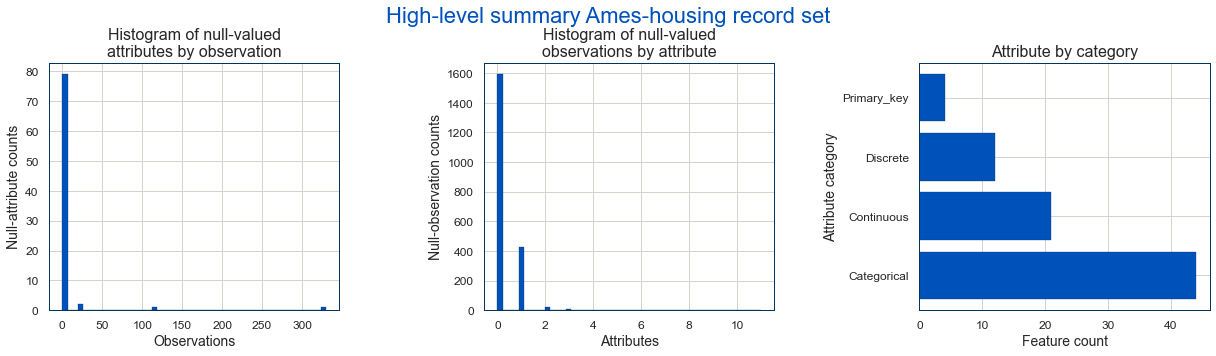

In [9]:
plt.rcParams["axes.edgecolor"] = '#003459'
plt.rcParams["axes.linewidth"] = 1
fig, axes = plt.subplots(nrows = 1,
                         ncols = 3,
                         figsize = (17, 5))
axes[0].hist(housing_raw.isna()
                       .sum(axis = 0),
             bins = 50,
             color = '#0051ba',
             edgecolor = '#003459');
axes[0].set_xlabel(xlabel = 'Observations',
                   fontsize = 14);
axes[0].set_ylabel(ylabel = 'Null-attribute counts',
                   fontsize = 14);
axes[0].grid(color = '#d7d2cb');
axes[0].set_title(label = 'Histogram of null-valued\nattributes by observation',
                  fontsize = 16)
axes[0].tick_params(labelsize = 12);
axes[1].hist(housing_raw.isna()
                       .sum(axis = 1),
             bins = 50,
             color = '#0051ba',
             edgecolor = '#003459');
axes[1].set_xlabel(xlabel = 'Attributes',
                   fontsize = 14);
axes[1].set_ylabel(ylabel = 'Null-observation counts',
                   fontsize = 14);
axes[1].grid(color = '#d7d2cb');
axes[1].set_title(label = 'Histogram of null-valued\nobservations by attribute',
                  fontsize = 16);
axes[1].tick_params(labelsize = 12);
axes[2].barh(width = ames_feature_cats,
             y = ames_feature_cats.index,
             color = '#0051ba',
             edgecolor = '#003459');
axes[2].tick_params(labelsize = 12);
axes[2].set_xlabel(xlabel = 'Feature count',
                   fontsize = 14);
axes[2].set_ylabel(ylabel = 'Attribute category',
                   fontsize = 14);
axes[2].grid(color = '#d7d2cb');
axes[2].set_title(label = 'Attribute by category',
                  fontsize = 16);

plt.suptitle(t = 'High-level summary Ames-housing record set',
             fontsize = 22,
             color = '#0051ba',
             va = 'bottom',
             y = 0.925);
plt.tight_layout()

plt.subplots_adjust(wspace = 0.5,
                    hspace = 0.5,
                    top = 0.825)
plt.savefig(os.path.join('./Graphics', 'DataDictSummy.png'),
            dpi = 150,
            transparent = True)

<font color = '#0051ba'>

We now do the data cleansing. We identified two attributes — `Lot_Frontage` and `Garage_Yr_Blt` — to be discarded. These attributes have substatial portions of missing values.  `Garage_Yr_Blt` in particular is very-closely correlated with `YearBuilt` attribute.  No obvious approach to attributing value to `Lot_Frontage` occurs.  We identified a small number of records for which no obvious approach to attributing missing values occured.

We use `pandas.DataFrame.dropna()` method to discard records. We select the records by specifying the `subset` option. Our `subset` is indicated by the presence of a `Drop record` statement in the `disposition` column of `data_dict_populated`. 

We drop attributes using the `pandas.DataFrame.drop(axis = 1)` method.
               
</color>

In [10]:
# Discard attributes
discarded_attributes =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard attribute' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()
discarded_records =\
data_dict_populated.set_index(keys = 'attribute')\
                   .loc[['Discard records' in disposition 
                         for disposition in data_dict_populated['Disposition']]]\
                   .index\
                   .tolist()
#
# Cleans, transform data.
housing_profile = housing_raw.dropna(axis = 0,
                                     how = 'any',
                                     subset = discarded_records)\
                             .drop(labels = discarded_attributes,
                                   axis = 1)\
                             .dropna(axis = 0,
                                     how = 'any')\
                             .set_index(keys = 'Id')
housing_profile = housing_raw.drop(labels = discarded_attributes,
                                   axis = 1)\
                             .set_index(keys = 'Id')



In [11]:
housing_profile.shape

(2051, 77)

In [12]:
housing_profile.loc[[1499, 2181], ['Neighborhood', 'GrLivArea', 'SalePrice']]

,Neighborhood,GrLivArea,SalePrice
Id,,,
1499,Edwards,5642,160000
2181,Edwards,5095,183850


In [13]:
# We have attributes with null values.  We conditionally attribute values
# based on the dataype.  Construct a dictionary for which the 
# keys are the attribute labels (column labels) with which null
# values and the values are the datatype. We cycle through each
# attribute and apply an pandas.DataFrame.fillna() method.  For 
# dype = "object", we apply "unspecified". We apply zeros
# for dtype = "float64"
attributes_with_nulls =\
pd.merge(left = pd.DataFrame(data = housing_profile.dtypes,
                             columns = ['dtypes']),
         right = pd.DataFrame(data = housing_profile.isna().any(axis = 0),
                              columns = ['has_nulls']),
         left_index = True,
         right_index = True).rename_axis(index = 'attribute')\
                            .reset_index(drop = False)\
                            .set_index(keys = 'has_nulls')\
                            .loc[True]\
                            .assign(dtypes = lambda Ξ : Ξ['dtypes'].apply(func = str))\
                            .set_index(keys = 'attribute')\
                            .to_dict()\
                            .get('dtypes')

for (attribute, dtype) in attributes_with_nulls.items():
    if dtype == 'object':
        housing_profile[attribute].fillna(value = 'unspecified',
                                          inplace = True)
    else:
        housing_profile[attribute].fillna(value = 0,
                                          inplace = True)




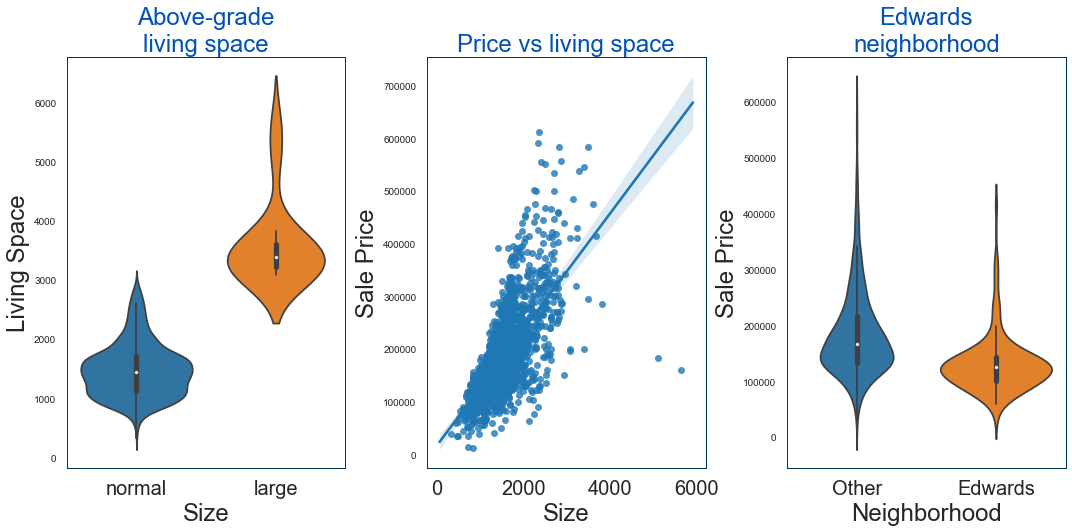

In [14]:
housing_prof_edwards = housing_profile.assign(
        Edwards = lambda Ξ : ['Edwards' if nbhd == 'Edwards'
                                else 'Other'
                                for nbhd in Ξ['Neighborhood']])
fig, axes = plt.subplots(1,3, figsize = (15, 7.5))
sns.violinplot(data = housing_profile,
               y = 'GrLivArea',
               x = 'GrLivAreaLarge',
               ax = axes[0])
sns.regplot(data = housing_profile,
               y = 'SalePrice',
               x = 'GrLivArea',
               ax = axes[1])
sns.violinplot(data = housing_prof_edwards,
               y = 'SalePrice',
               x = 'Edwards',
               ax = axes[2])
axes[0].set_title(label = 'Above-grade\nliving space',
                  fontsize = 24,
                  color = '#0051ba')
axes[1].set_title(label = 'Price vs living space',
                  fontsize = 24,
                  color = '#0051ba');
axes[2].set_title(label = 'Edwards\nneighborhood',
                  fontsize = 24,
                  color = '#0051ba');
axes[0].set_xlabel(xlabel = 'Size',
                   fontsize = 24)
axes[1].set_xlabel(xlabel = 'Size',
                   fontsize = 24)
axes[2].set_xlabel(xlabel = 'Neighborhood',
                   fontsize = 24)
axes[0].set_ylabel(ylabel = 'Living Space',
                   fontsize = 24)
axes[1].set_ylabel(ylabel = 'Sale Price',
                   fontsize = 24)
axes[2].set_ylabel(ylabel = 'Sale Price',
                   fontsize = 24)
axes[0].tick_params(labelsize = 20,
                    axis = 'x')
axes[1].tick_params(labelsize = 20,
                    axis = 'x')
axes[2].tick_params(labelsize = 20,
                    axis = 'x')
fig.subplots_adjust(wspace = 0.35)
plt.tight_layout()
plt.savefig(os.path.join('./Graphics', 'EdwardsConundrum.png'),
            dpi = 150)

In [15]:
# Verify that null values are populated.
pd.merge(left = pd.DataFrame(data = housing_profile.dtypes,
                             columns = ['dtypes']),
         right = pd.DataFrame(data = housing_profile.isna().any(axis = 0),
                              columns = ['has_nulls']),
         left_index = True,
         right_index = True).set_index(keys = 'has_nulls')\
                            .index\
                            .any()

False

In [16]:
1499 in set(housing_profile.index)

True

In [17]:
# Now, begin visualizing Response-variable SalesPrice by 
# data types, attributes. We begin with categoricals.  We
# identify our categoricals by their designation in the
# data dictionary.
categoricals = data_dict_populated.set_index(keys = 'attribute',
                                             drop = False)\
                                  .sort_index(axis = 0)\
                                  .set_index(keys = 'cat_vars',
                                             drop = False)\
                                  .loc['Categorical', 'attribute']\
                                  .tolist()
categorical_paritions = partition_list(parted_list = categoricals,
                                       partition_counts = 3)


<font color = '#0051ba'>

## 🅒 **Influential-variable analysis**.  Ascertain which variables are most-likely influential for our response variable `SalePrice`.  We have three classes of variables.
    
</font>

In [18]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##
# Identify influential categorical variables. Solve the reciprocal problem.
# Categoricals are influential with sales price if price indicates the
# category.  Our reciprocal problem therefore is to solve a multinomial
# regression problem for each categorical to see how well the SalesPrice
# predicts it.  We take the categoricals for which the associated model
# accuracy scores above a specified threshold.
categ_by_price = dict()
cat_var = categoricals[0]
for cat_var in categoricals:
    cat_log_fit = LogisticRegression(multi_class = 'multinomial',
                                     solver = 'lbfgs')
    cat_log_fit.fit(X = housing_profile[['SalePrice']],
                    y = housing_profile[cat_var])
    categ_by_price.update({cat_var : cat_log_fit.score(X = housing_profile[['SalePrice']],
                                                       y = housing_profile[cat_var])})
influential_categoricals = set([key
                                for (key, val) in categ_by_price.items()
                                if val >= 0.55] + ['Neighborhood']).union({'GrLivAreaLarge'})

len(influential_categoricals)

33

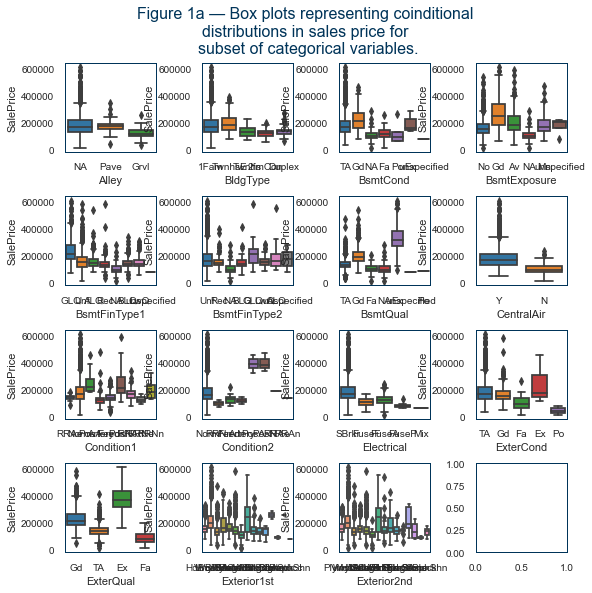

In [19]:
fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(categorical_paritions.get(0))))),
                         int(np.ceil(np.sqrt(len(categorical_paritions.get(0))))),
                         figsize = (9,9))
plt_axis = dict(enumerate(np.ndarray.flatten(axes)))
cat_vars = dict(enumerate(categorical_paritions.get(0)))

for axis_idx in cat_vars.keys():
    sns.boxplot(y = housing_profile['SalePrice'],
                x = housing_profile[cat_vars.get(axis_idx)],
                ax = plt_axis.get(axis_idx))

fig.subplots_adjust(wspace = 0.5)
fig.subplots_adjust(hspace = 0.5)

plt.suptitle(t = 'Figure 1a — Box plots representing coinditional \n' +\
                   'distributions in sales price for \n' +\
                   'subset of categorical variables.',
             va = 'top',
             y = .9675,
             color = '#003459',
             fontsize = 16);



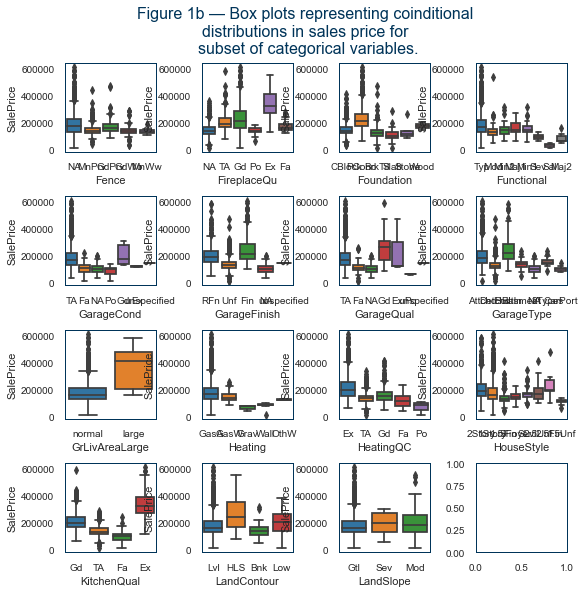

In [20]:
fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(categorical_paritions.get(1))))),
                         int(np.ceil(np.sqrt(len(categorical_paritions.get(1))))),
                         figsize = (9,9))
plt_axis = dict(enumerate(np.ndarray.flatten(axes)))
cat_vars = dict(enumerate(categorical_paritions.get(1)))

for axis_idx in cat_vars.keys():
    sns.boxplot(y = housing_profile['SalePrice'],
                x = housing_profile[cat_vars.get(axis_idx)],
                ax = plt_axis.get(axis_idx))

fig.subplots_adjust(wspace = 0.5)
fig.subplots_adjust(hspace = 0.5)

plt.suptitle(t = 'Figure 1b — Box plots representing coinditional \n' +\
                   'distributions in sales price for \n' +\
                   'subset of categorical variables.',
             va = 'top',
             y = .9675,
             color = '#003459',
             fontsize = 16);



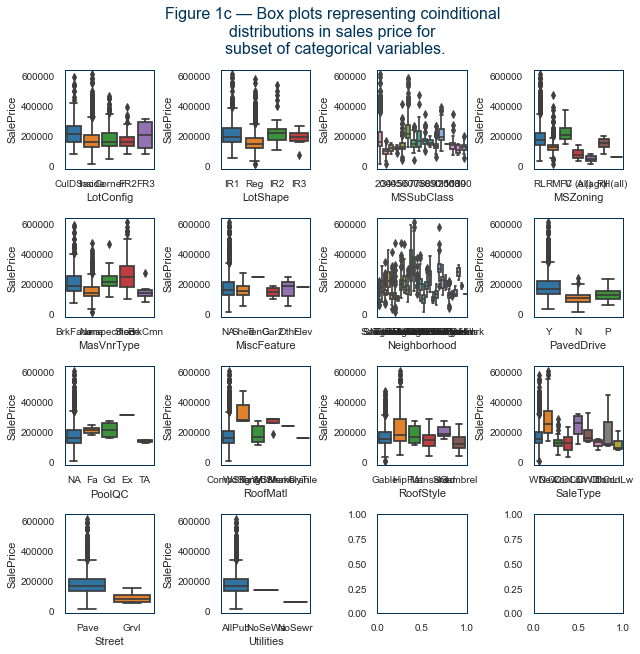

In [21]:
fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(categorical_paritions.get(2))))),
                         int(np.ceil(np.sqrt(len(categorical_paritions.get(2))))),
                         figsize = (10, 10))
plt_axis = dict(enumerate(np.ndarray.flatten(axes)))
cat_vars = dict(enumerate(categorical_paritions.get(2)))

for axis_idx in cat_vars.keys():
    sns.boxplot(y = housing_profile['SalePrice'],
                x = housing_profile[cat_vars.get(axis_idx)],
                ax = plt_axis.get(axis_idx))

fig.subplots_adjust(wspace = 0.75)
fig.subplots_adjust(hspace = 0.5)

plt.suptitle(t = 'Figure 1c — Box plots representing coinditional \n' +\
                   'distributions in sales price for \n' +\
                   'subset of categorical variables.',
             va = 'top',
             y = .9675,
             color = '#003459',
             fontsize = 16);

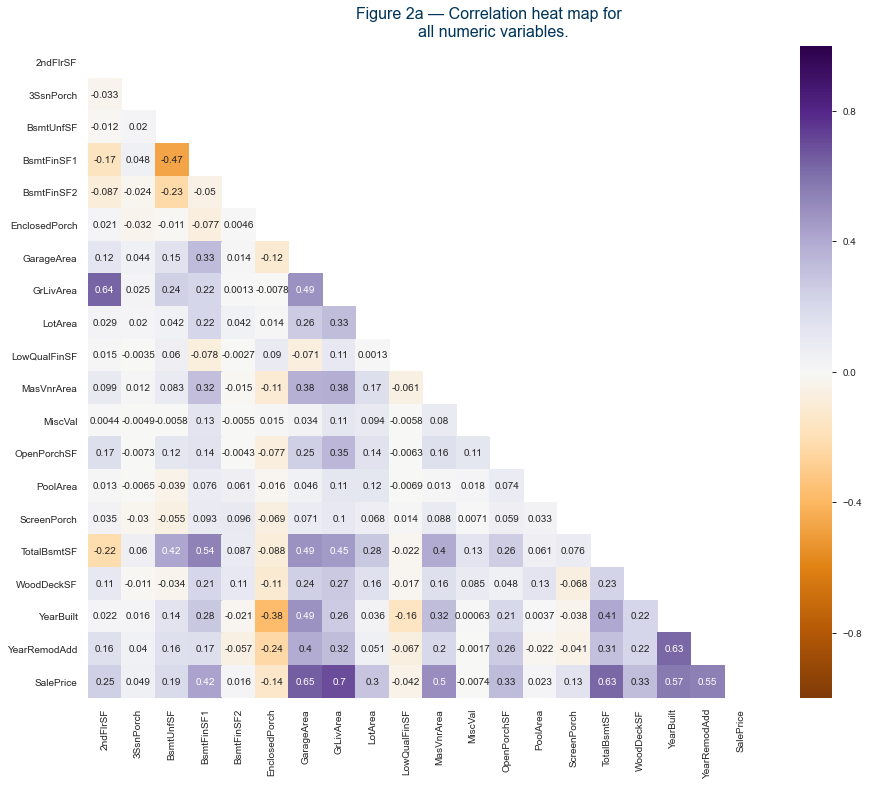

In [22]:
#
# Now, we visualize our continuous numerical variables. We look at pair-plot
# scatters and at correlation heatmaps.
numericals =data_dict_populated.loc[['Discard attribute.' not in dispos
                                         for dispos in data_dict_populated['Disposition']]]\
                                .set_index(keys = 'cat_vars')\
                                .loc['Continuous', 'attribute']\
                                .tolist()
plt.figure(figsize=(15,12))

numericals_corr = housing_profile[numericals + ['SalePrice']].corr()
mask = np.zeros_like(numericals_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = numericals_corr,
            cmap = 'PuOr',
            vmin = -1,
            vmax = 1,
            mask = mask,
            annot = True)
plt.suptitle(t = 'Figure 2a — Correlation heat map for  \n'+\
                   'all numeric variables.',
             va = 'top',
             y = .925,
             color = '#003459',
             fontsize = 16);

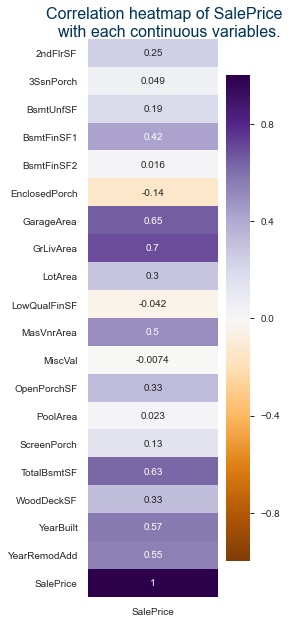

In [23]:
plt.figure(figsize=(0.75,10))
sns.heatmap(data = housing_profile[numericals + ['SalePrice']]\
                                  .corr()\
                                  .loc[['SalePrice']].T,
            cmap = 'PuOr',
            vmin = -1,
            vmax = 1,
            annot = True)
plt.suptitle(t = 'Correlation heatmap of SalePrice  \n'+\
                   'with each continuous variables.',
             va = 'bottom',
             ha = 'center',
             x = 2.5,
             y = 0.9,
             color = '#003459',
             fontsize = 16);
plt.subplots_adjust(left = 1,
                    right = 4,
                    top = 0.9)

plt.savefig(os.path.join('./Graphics', 'Continuous Explanatories Correlation Heatmap.png'),
            dpi = 150,
            transparent = True,
            bbox_inches = 'tight')

In [24]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##
# Identify influential continuous explanatory variables. These are variables for
# whith the correlation with the response variable exceeds a specified threshold.
sales_price_cont_corr = housing_profile[numericals + ['SalePrice']]\
                                      .corr()\
                                      .loc['SalePrice']
influental_continuous = sales_price_cont_corr.loc[(np.abs(sales_price_cont_corr) >= 0.45) &\
                                                   (np.abs(sales_price_cont_corr) != 1)].index.tolist()
influental_continuous

['GarageArea',
 'GrLivArea',
 'MasVnrArea',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

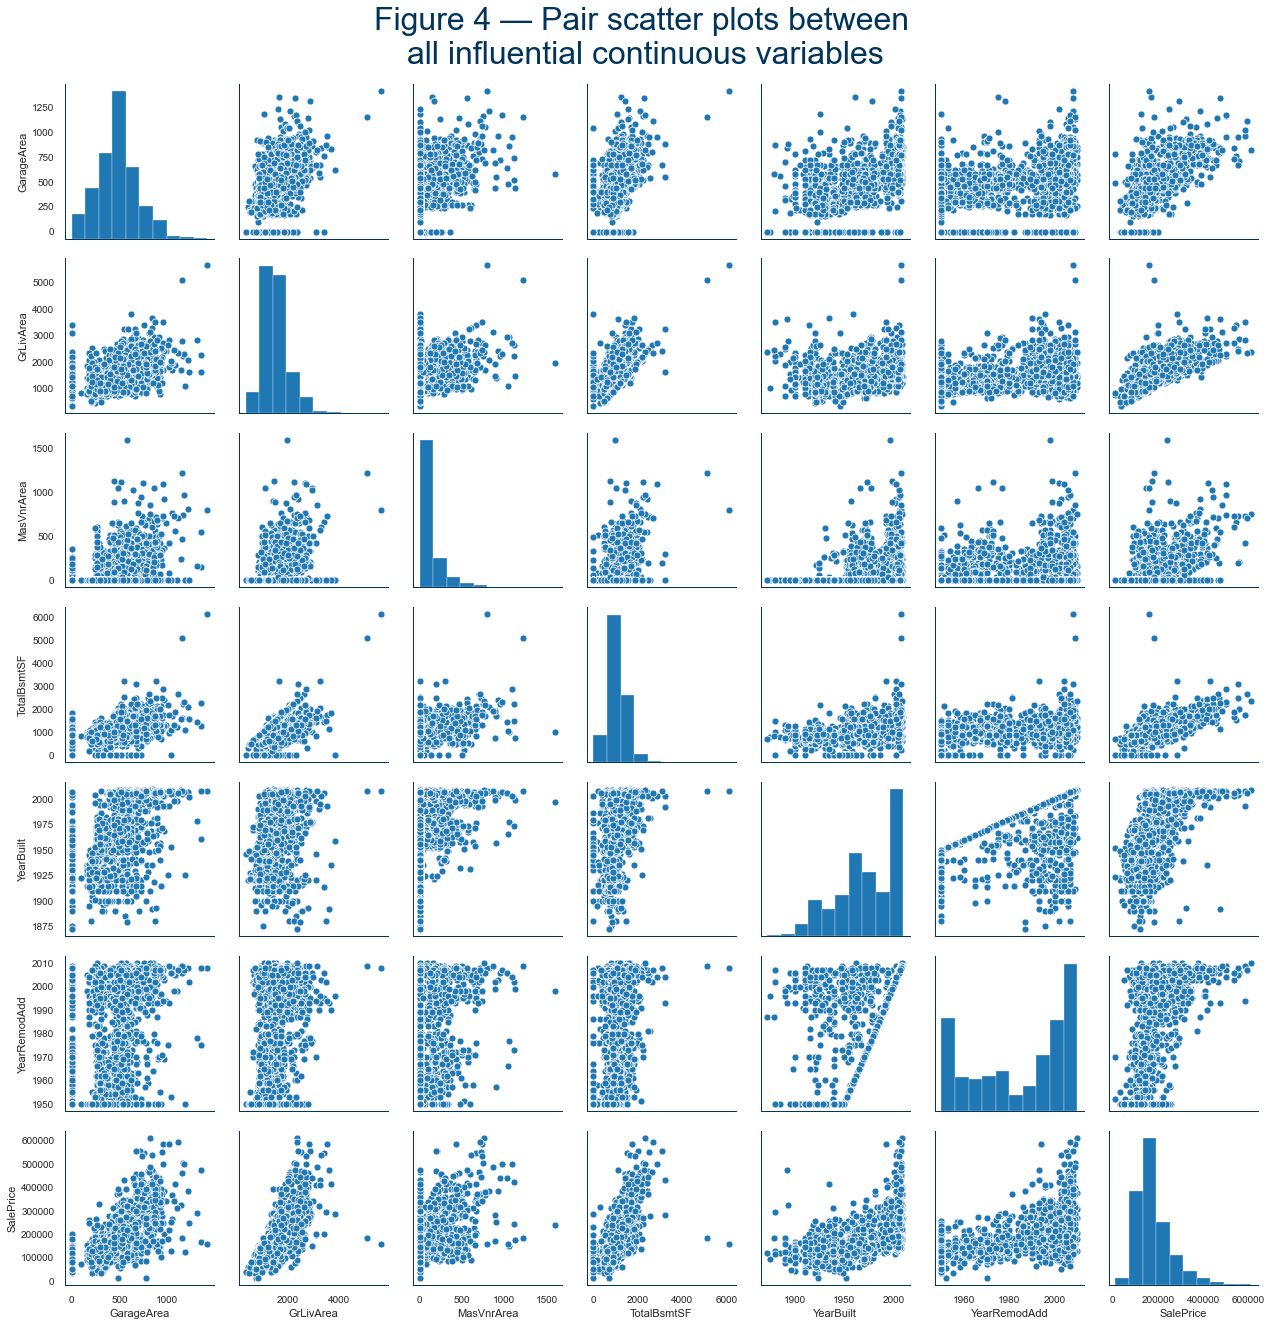

In [25]:
sns.pairplot(data = housing_profile[influental_continuous +  ['SalePrice']])
plt.suptitle(t = "Figure 4 — Pair scatter plots between \n" +\
                   "all influential continuous variables",
             va = 'bottom',
             y = 1.,
             color = '#003459',
             fontsize = 32);

In [26]:
discretes = data_dict_populated.set_index(keys = 'attribute',
                                                  drop = False)\
                                .drop(labels = ['Id', 'PID', 'SalePrice'] +\
                                                discarded_attributes)\
                                .sort_index()\
                                .set_index(keys = 'cat_vars',
                                           drop = False)\
                                .loc['Discrete', 'attribute']\
                                .tolist()

discretes

['BedroomAbvGr',
 'BsmtFullBath',
 'BsmtHalfBath',
 'Fireplaces',
 'FullBath',
 'GarageCars',
 'HalfBath',
 'KitchenAbvGr',
 'OverallCond',
 'OverallQual',
 'TotRmsAbvGrd']

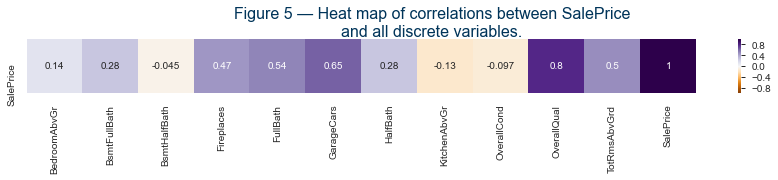

In [27]:
discretes
plt.figure(figsize=(15,1))
sns.heatmap(data = housing_profile[discretes + ['SalePrice']]\
                                  .corr()\
                                  .loc[['SalePrice']],
            cmap = 'PuOr',
            vmin = -1,
            vmax = 1,
            annot = True)
plt.suptitle(t = 'Figure 5 — Heat map of correlations between SalePrice\n'+\
                   'and all discrete variables.',
             va = 'top',
             y = 1.333,
             color = '#003459',
             fontsize = 16);

In [28]:
## 🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳🧭🌡⏳ ##

sales_price_discr_corr = housing_profile[discretes + ['SalePrice']]\
                                      .corr()\
                                      .loc['SalePrice']
influental_discretes = sales_price_discr_corr.loc[(np.abs(sales_price_discr_corr) >= 0.45) &\
                                                   (np.abs(sales_price_discr_corr) != 1)].index.tolist()
influental_discretes

['Fireplaces', 'FullBath', 'GarageCars', 'OverallQual', 'TotRmsAbvGrd']

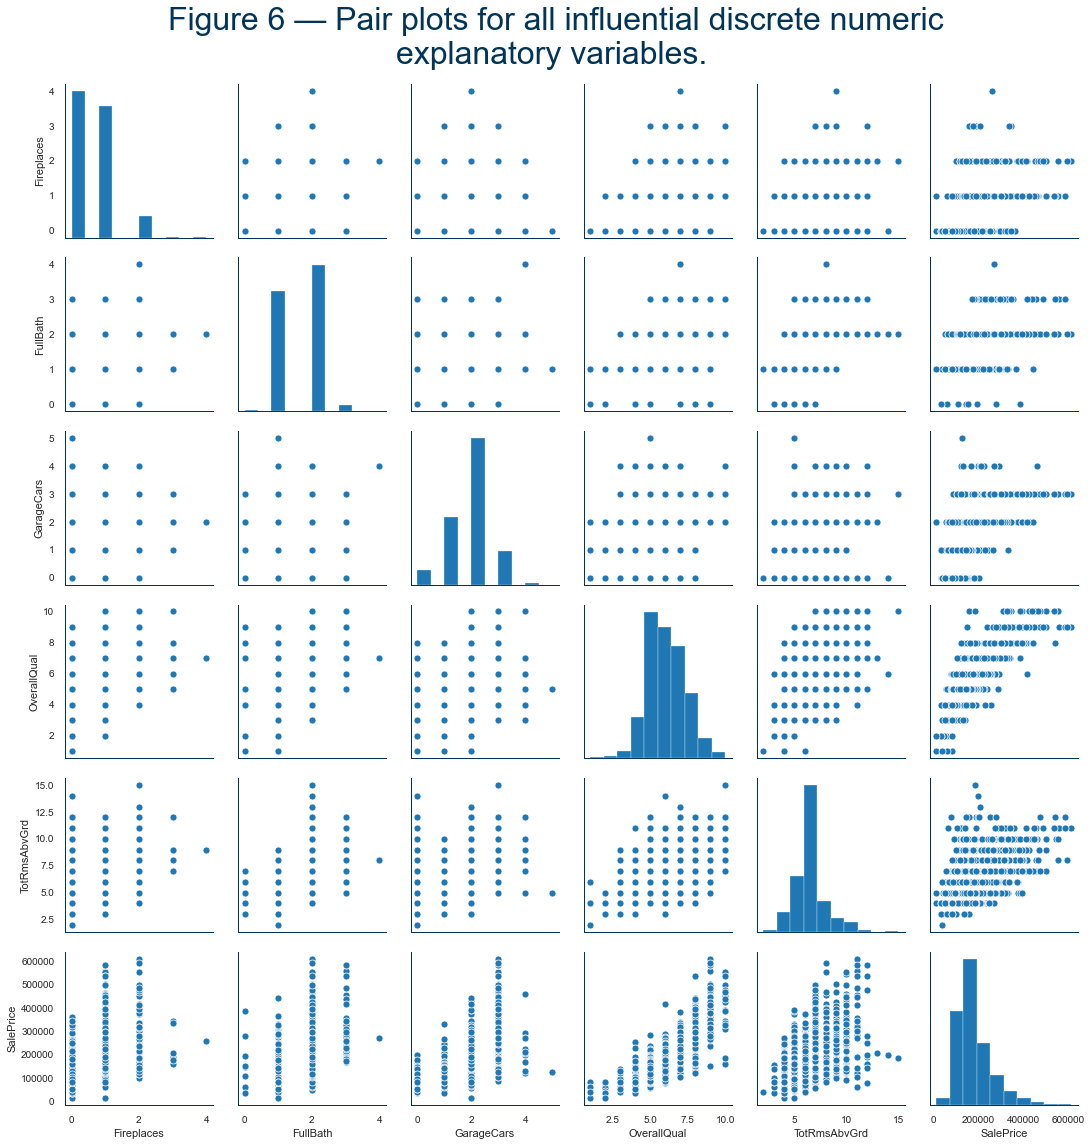

In [29]:
sns.pairplot(data =  housing_profile[influental_discretes + ['SalePrice']])
plt.suptitle(t = "Figure 6 — Pair plots for all influential discrete numeric\nexplanatory variables. ",
             va = 'bottom',
             y = 1.,
             color = '#003459',
             fontsize = 32);

In [30]:
housing_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 77 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      2051 non-null   int64  
 1   MSZoning        2051 non-null   object 
 2   LotArea         2051 non-null   int64  
 3   Street          2051 non-null   object 
 4   Alley           2051 non-null   object 
 5   LotShape        2051 non-null   object 
 6   LandContour     2051 non-null   object 
 7   Utilities       2051 non-null   object 
 8   LotConfig       2051 non-null   object 
 9   LandSlope       2051 non-null   object 
 10  Neighborhood    2051 non-null   object 
 11  Condition1      2051 non-null   object 
 12  Condition2      2051 non-null   object 
 13  BldgType        2051 non-null   object 
 14  HouseStyle      2051 non-null   object 
 15  OverallQual     2051 non-null   int64  
 16  OverallCond     2051 non-null   int64  
 17  YearBuilt       2051 non-null   i

<font color = '#0051ba'>

## 🅓 **Feature engineering.** 

</font>

In [31]:
ames_house_anova = dict()

In [32]:
## 🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂🐘🐫🐪🐎🐕🐂 ##
# FEATURE ENGINEERING.  Derive dummy variables for the influential categorical
# variables in both the training and unseen data.
sac_house_model_mtx0 = pd.get_dummies(
            data = housing_profile[set().union(*[influential_categoricals,
                                                  influental_continuous,
                                                  influental_discretes,
                                                 ['SalePrice']])],
            columns = influential_categoricals,
            drop_first = True)

#
sac_model_tts = dict(zip(['X_train', 'X_test', 'y_train', 'y_test'],
                         train_test_split(sac_house_model_mtx0.drop(labels = 'SalePrice',
                                                                    axis = 1),
                                          sac_house_model_mtx0['SalePrice'],
                                          train_size = 0.75,
                                          test_size = 0.25,
                                          random_state = 30214)))
sac_model_scaler = StandardScaler()
sac_model_scaler.fit(sac_model_tts.get('X_train'))
sac_model_tts.update({'X_train_scaled' : sac_model_scaler.transform(sac_model_tts.get('X_train')),
                      'X_test_scaled' : sac_model_scaler.transform(sac_model_tts.get('X_test'))})

In [33]:
sac_house_model_mtx0.shape

(2051, 178)

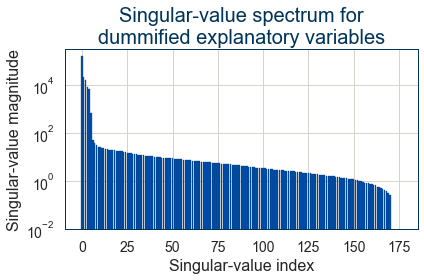

In [34]:
(𝗨, 𝝨, 𝗩ᵀ) = np.linalg.svd(a = sac_house_model_mtx0.drop(labels = 'SalePrice',
                                                         axis = 1)
                                                   .to_numpy(),
                           full_matrices = False)
plt.figure(figsize = (6,4));
plt.bar(x = range(len(𝝨)),
        height = 𝝨,
        color = '#0051ba',
        edgecolor = '#003459')
plt.yscale('log')
plt.ylim(bottom = 10**(-2),
         top = 3 * 10**5)
plt.tick_params(labelsize = 14,
                color = '#003459')
plt.grid(color = '#d7d2cb')
plt.xlabel(xlabel = 'Singular-value index',
           fontsize = 16);
plt.ylabel(ylabel = 'Singular-value magnitude',
           fontsize = 16);
plt.title(label = 'Singular-value spectrum for\ndummified explanatory variables',
          fontsize = 20,
          color = '#003459');

plt.tight_layout()
plt.savefig(os.path.join('./Graphics', 'Dummified-Explanatory Sing-Value Spectrum.png'),
            dpi = 150,
            transparent = True)


In [35]:
sum(np.cumsum(𝝨)/np.sum(𝝨) <= 0.99)

4

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:    5.0s finished


Train 𝘙² : 0.8142047427836222
Test 𝘙² : 0.8210264230987147


{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 30}

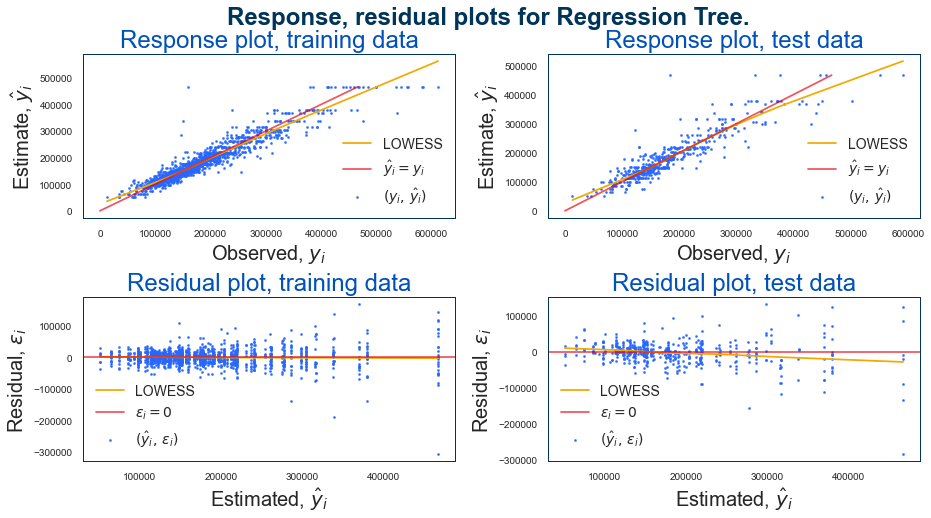

In [36]:
ames_regtree_gs = GridSearchCV(estimator = DecisionTreeRegressor(criterion = 'mse',
                                                                    random_state = 30214),
                                  param_grid = {'max_depth' : [7, 8, 9, 10],
                                                'min_samples_split' : [25, 30, 35, 40],
                                                'min_samples_leaf' : [5, 6, 7]},
                                  refit = True,
                                  cv = 5,
                                  n_jobs = 10,
                                  verbose = True)
ames_regtree_gs.fit(X = sac_model_tts.get('X_train'),
                    y = sac_model_tts.get('y_train'))
print('Train 𝘙² : {}\nTest 𝘙² : {}'
      .format(ames_regtree_gs.best_score_,
              ames_regtree_gs.score(X = sac_model_tts.get('X_test'),
                                    y = sac_model_tts.get('y_test'))))
response_residual_plots(y_test = sac_model_tts.get('y_test'), 
                        y_train = sac_model_tts.get('y_train'), 
                        fit_test = ames_regtree_gs.predict(X = sac_model_tts.get('X_test') ), 
                        fit_train = ames_regtree_gs.predict(X = sac_model_tts.get('X_train') ), 
                        plot_title = 'Response, residual plots for Regression Tree.')
ames_regtree_gs.best_params_

In [38]:
ames_house_anova.update(
    {'Regresion Tree' : {'Train' : anova(y_observed = sac_model_tts.get('y_train'), 
                                          y_estimated = ames_regtree_gs.predict(X = sac_model_tts.get('X_train') )),
                         'Test' : anova(y_observed = sac_model_tts.get('y_test'), 
                                      y_estimated = ames_regtree_gs.predict(X = sac_model_tts.get('X_test') ))}})


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:   17.6s finished


Train 𝘙² : 0.8488473070165657
Test 𝘙² : 0.829424211573175


{'learning_rate': 0.44668359215096315, 'loss': 'linear'}

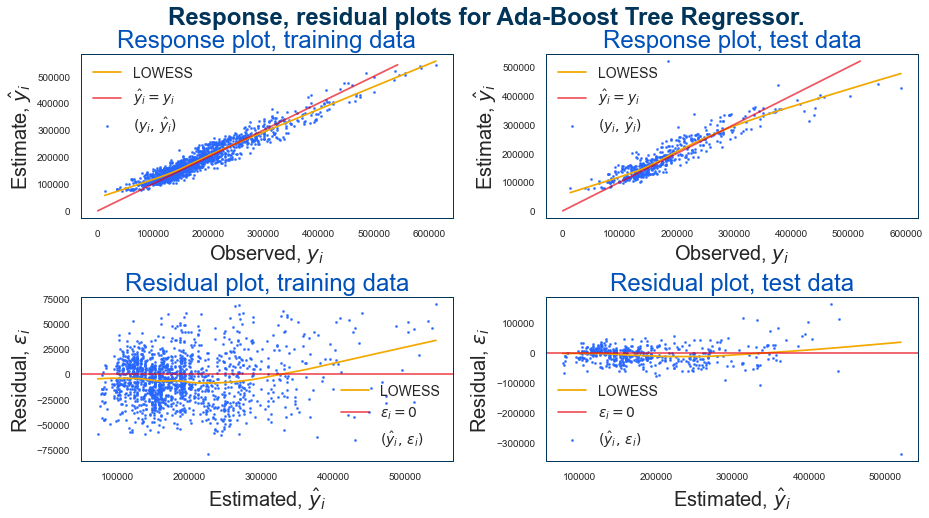

In [39]:
# Conduct a gridsearch over "tuning" parameters for a
# Ada-Boost regressor.
ames_ada_gs = GridSearchCV(estimator = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 4),
                                                            random_state = 30214,
                                                            n_estimators = 100),
                              param_grid = {'learning_rate' : np.logspace(start = -0.35,
                                                                          stop = -0.15,
                                                                          num = 7),
                                            'loss' : ['linear', 'square']},
                              refit = True,
                              cv = 5,
                              n_jobs = 10,
                              verbose = True)
ames_ada_gs.fit(X = sac_model_tts.get('X_train'),
                y = sac_model_tts.get('y_train'))
print('Train 𝘙² : {}\nTest 𝘙² : {}'
      .format(ames_ada_gs.best_score_,
              ames_ada_gs.score(X = sac_model_tts.get('X_test'),
                                y = sac_model_tts.get('y_test'))))
response_residual_plots(y_test = sac_model_tts.get('y_test'), 
                        y_train = sac_model_tts.get('y_train'), 
                        fit_test = ames_ada_gs.predict(X = sac_model_tts.get('X_test') ), 
                        fit_train = ames_ada_gs.predict(X = sac_model_tts.get('X_train') ), 
                        plot_title = 'Response, residual plots for Ada-Boost Tree Regressor.')
ames_ada_gs.best_params_

In [40]:
ames_house_anova.update(
    {'Ada-Boost Tree' : {'Train' : anova(y_observed = sac_model_tts.get('y_train'), 
                                          y_estimated = ames_ada_gs.predict(X = sac_model_tts.get('X_train') )),
                         'Test' : anova(y_observed = sac_model_tts.get('y_test'), 
                                      y_estimated = ames_ada_gs.predict(X = sac_model_tts.get('X_test') ))}})
ames_house_anova

{'Regresion Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 982984.2719206946,
   'root_SSR': 2951907.8368510236,
   'SST-SSE-SSR': 0.0,
   'R2': 0.9001801356955166},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 756536.9555734164,
   'root_SSR': 1783418.1135097453,
   'SST-SSE-SSR': -554980484474.9487,
   'R2': 0.8210264230987148}},
 'Ada-Boost Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 908835.225188148,
   'root_SSR': 2886098.1714201504,
   'SST-SSE-SSR': 524473834488.4199,
   'R2': 0.9146714943827372},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 738574.624236565,
   'root_SSR': 1648636.6875244286,
   'SST-SSE-SSR': -65547554749.69922,
   'R2': 0.829424211573175}}}

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   35.9s
[Parallel(n_jobs=10)]: Done 400 out of 400 | elapsed:  1.4min finished


Train 𝘙² : 0.8785248834479765
Test 𝘙² : 0.874892569108122


{'max_features': 115, 'max_samples': 0.45, 'oob_score': True}

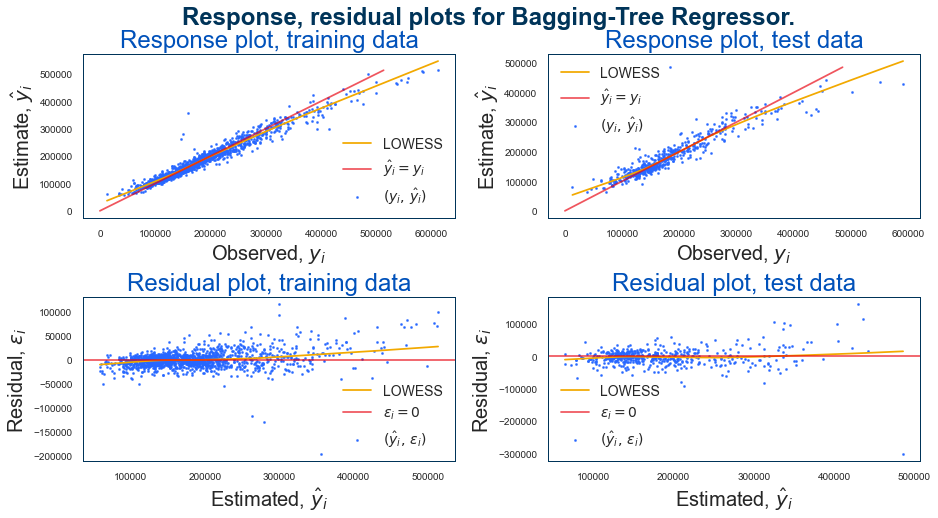

In [41]:
# Conduct a gridsearch over "tuning" parameters for a
# Bagging regressor.
ames_bagtree_gs = GridSearchCV(estimator = BaggingRegressor(
                                                    random_state = 30214,
                                                    n_estimators = 100),
                                  param_grid = {'max_samples' : np.linspace(start = 0.45,
                                                                            stop = 0.5,
                                                                            num = 4),
                                                'max_features' : range(110,120),
                                                'oob_score' : [True, False]},

                                  refit = True,
                                  cv = 5,
                                  n_jobs = 10,
                                  verbose = True)
ames_bagtree_gs.fit(X = sac_model_tts.get('X_train'),
                    y = sac_model_tts.get('y_train'))
print('Train 𝘙² : {}\nTest 𝘙² : {}'
      .format(ames_bagtree_gs.best_score_,
              ames_bagtree_gs.score(X = sac_model_tts.get('X_test'),
                                    y = sac_model_tts.get('y_test'))))
response_residual_plots(y_test = sac_model_tts.get('y_test'), 
                        y_train = sac_model_tts.get('y_train'), 
                        fit_test = ames_bagtree_gs.predict(X = sac_model_tts.get('X_test') ), 
                        fit_train = ames_bagtree_gs.predict(X = sac_model_tts.get('X_train') ), 
                        plot_title = 'Response, residual plots for Bagging-Tree Regressor.')
ames_bagtree_gs.best_params_

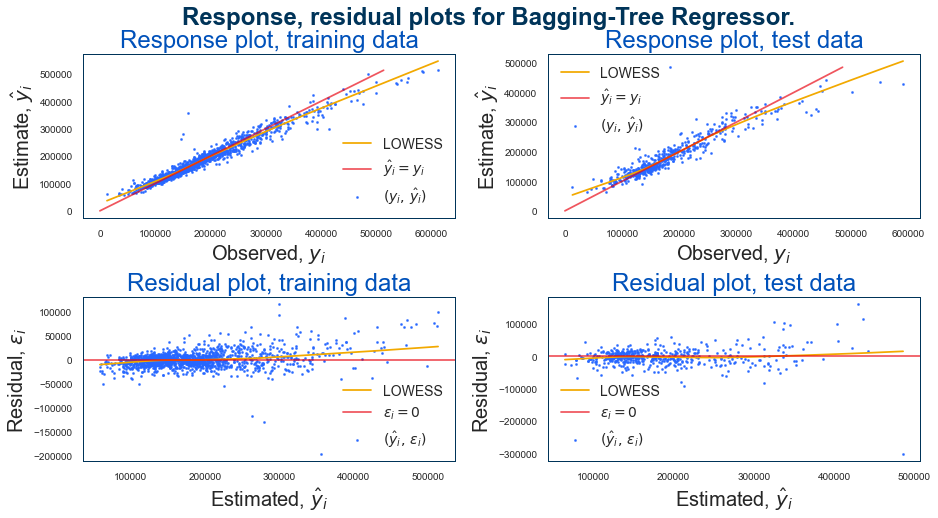

In [63]:
response_residual_plots(y_test = sac_model_tts.get('y_test'), 
                        y_train = sac_model_tts.get('y_train'), 
                        fit_test = ames_bagtree_gs.predict(X = sac_model_tts.get('X_test') ), 
                        fit_train = ames_bagtree_gs.predict(X = sac_model_tts.get('X_train') ), 
                        plot_title = 'Response, residual plots for Bagging-Tree Regressor.')
plt.savefig(os.path.join('./Graphics', 'Bagg-Tree Resp Resid Plots.png'),
            dpi = 150,
            transparent = True,
            bbox_inches = 'tight')


In [42]:
ames_house_anova.update(
    {'Bagging-Tree Regressor' : {'Train' : anova(y_observed = sac_model_tts.get('y_train'), 
                                                  y_estimated = ames_bagtree_gs.predict(X = sac_model_tts.get('X_train') )),
                                 'Test' : anova(y_observed = sac_model_tts.get('y_test'), 
                                              y_estimated = ames_bagtree_gs.predict(X = sac_model_tts.get('X_test') ))}})
ames_house_anova

{'Regresion Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 982984.2719206946,
   'root_SSR': 2951907.8368510236,
   'SST-SSE-SSR': 0.0,
   'R2': 0.9001801356955166},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 756536.9555734164,
   'root_SSR': 1783418.1135097453,
   'SST-SSE-SSR': -554980484474.9487,
   'R2': 0.8210264230987148}},
 'Ada-Boost Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 908835.225188148,
   'root_SSR': 2886098.1714201504,
   'SST-SSE-SSR': 524473834488.4199,
   'R2': 0.9146714943827372},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 738574.624236565,
   'root_SSR': 1648636.6875244286,
   'SST-SSE-SSR': -65547554749.69922,
   'R2': 0.829424211573175}},
 'Bagging-Tree Regressor': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 682044.7994894241,
   'root_SSR': 2821283.610548414,
   'SST-SSE-SSR': 1255191636446.2861,
   'R2': 0.9519437762801731},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 6

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:   10.2s finished


Train 𝘙² : 0.8668350169738639
Test 𝘙² : 0.8629958741244212


{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 3}

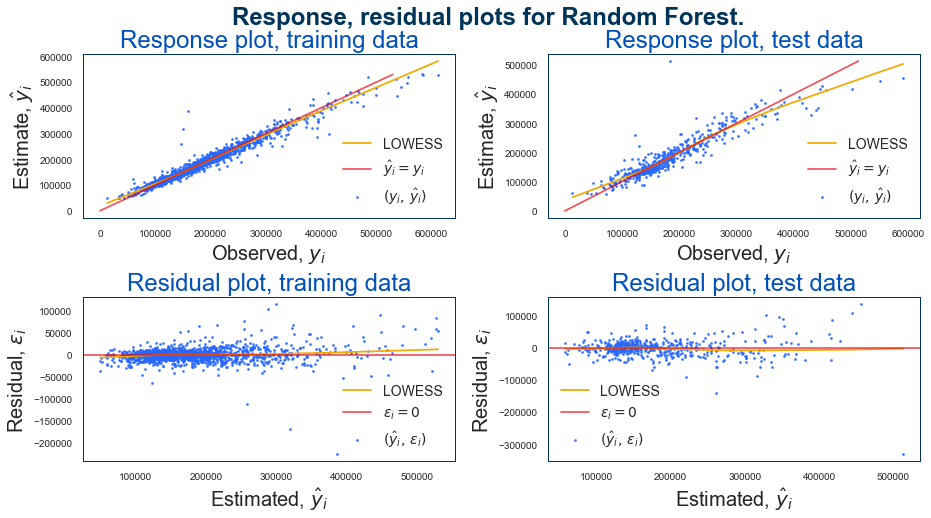

In [46]:
# Conduct a gridsearch over "tuning" parameters for a
# Random-forest Regressor.
ames_randfor_gs = GridSearchCV(estimator = RandomForestRegressor(random_state = 30214,
                                                                    n_estimators = 50,
                                                                    criterion = 'mse'),
                              param_grid = {'max_depth' : range(10, 15 ,2),
                                            'min_samples_split' : range(3,5),
                                            'min_samples_leaf' : range(3,5)},
                              refit = True,
                              cv = 5,
                              n_jobs = 10,
                              verbose = True)
ames_randfor_gs.fit(X = sac_model_tts.get('X_train'),
                    y = sac_model_tts.get('y_train'))
print('Train 𝘙² : {}\nTest 𝘙² : {}'
      .format(ames_randfor_gs.best_score_,
              ames_randfor_gs.score(X = sac_model_tts.get('X_test'),
                                    y = sac_model_tts.get('y_test'))))
response_residual_plots(y_test = sac_model_tts.get('y_test'), 
                        y_train = sac_model_tts.get('y_train'), 
                        fit_test = ames_randfor_gs.predict(X = sac_model_tts.get('X_test') ), 
                        fit_train = ames_randfor_gs.predict(X = sac_model_tts.get('X_train') ), 
                        plot_title = 'Response, residual plots for Random Forest.')
ames_randfor_gs.best_params_

In [47]:
ames_house_anova.update(
    {'Random-Forest Regressor' : {'Train' : anova(y_observed = sac_model_tts.get('y_train'), 
                                                  y_estimated = ames_randfor_gs.predict(X = sac_model_tts.get('X_train') )),
                                 'Test' : anova(y_observed = sac_model_tts.get('y_test'), 
                                              y_estimated = ames_randfor_gs.predict(X = sac_model_tts.get('X_test') ))}})

ames_house_anova

{'Regresion Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 982984.2719206946,
   'root_SSR': 2951907.8368510236,
   'SST-SSE-SSR': 0.0,
   'R2': 0.9001801356955166},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 756536.9555734164,
   'root_SSR': 1783418.1135097453,
   'SST-SSE-SSR': -554980484474.9487,
   'R2': 0.8210264230987148}},
 'Ada-Boost Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 908835.225188148,
   'root_SSR': 2886098.1714201504,
   'SST-SSE-SSR': 524473834488.4199,
   'R2': 0.9146714943827372},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 738574.624236565,
   'root_SSR': 1648636.6875244286,
   'SST-SSE-SSR': -65547554749.69922,
   'R2': 0.829424211573175}},
 'Bagging-Tree Regressor': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 682044.7994894241,
   'root_SSR': 2821283.610548414,
   'SST-SSE-SSR': 1255191636446.2861,
   'R2': 0.9519437762801731},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 6

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 160 out of 160 | elapsed:    5.5s finished


Train 𝘙² : 0.7531017832770998
Test 𝘙² : 0.7598776957130858


{'algorithm': 'kd_tree', 'n_neighbors': 8, 'weights': 'distance'}

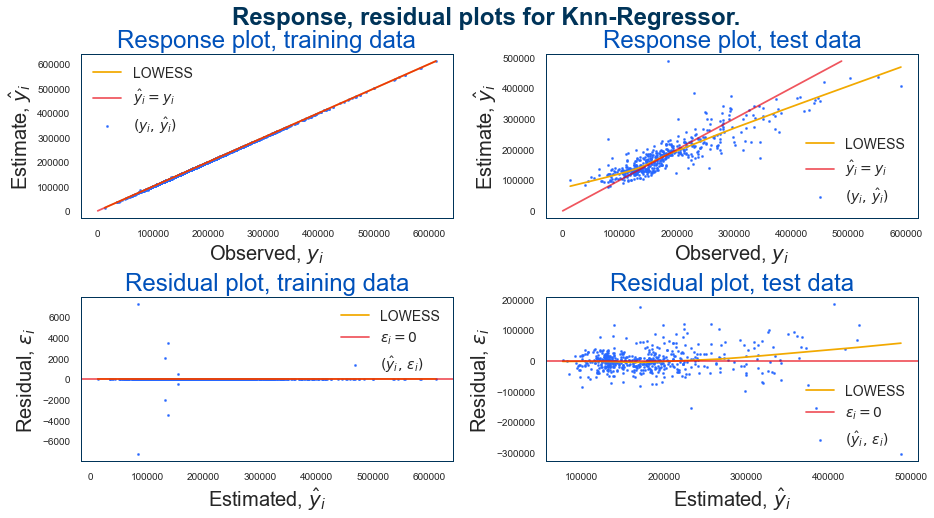

In [48]:
# Conduct a gridsearch over "tuning" parameters for a
# knn regressor.
ames_knnreg_gs = GridSearchCV(estimator = KNeighborsRegressor(),
                                  param_grid = {'n_neighbors' : range(2,10),
                                                'algorithm' : ['ball_tree', 'kd_tree'],
                                                'weights' : ['uniform', 'distance']},

                                  refit = True,
                                  cv = 5,
                                  n_jobs = 10,
                                  verbose = True)
ames_knnreg_gs.fit(X = sac_model_tts.get('X_train_scaled'),
                   y = sac_model_tts.get('y_train'))
print('Train 𝘙² : {}\nTest 𝘙² : {}'
      .format(ames_knnreg_gs.best_score_,
              ames_knnreg_gs.score(X = sac_model_tts.get('X_test_scaled'),
                                    y = sac_model_tts.get('y_test'))))
response_residual_plots(y_test = sac_model_tts.get('y_test'), 
                        y_train = sac_model_tts.get('y_train'), 
                        fit_test = ames_knnreg_gs.predict(X = sac_model_tts.get('X_test_scaled') ), 
                        fit_train = ames_knnreg_gs.predict(X = sac_model_tts.get('X_train_scaled') ), 
                        plot_title = 'Response, residual plots for Knn-Regressor.')
ames_knnreg_gs.best_params_


In [49]:
ames_house_anova.update(
    {'Knn Regressor' : {'Train' : anova(y_observed = sac_model_tts.get('y_train'), 
                                        y_estimated = ames_knnreg_gs.predict(X = sac_model_tts.get('X_train_scaled') )),
                       'Test' : anova(y_observed = sac_model_tts.get('y_test'), 
                                    y_estimated = ames_knnreg_gs.predict(X = sac_model_tts.get('X_test_scaled') ))}})
ames_house_anova


{'Regresion Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 982984.2719206946,
   'root_SSR': 2951907.8368510236,
   'SST-SSE-SSR': 0.0,
   'R2': 0.9001801356955166},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 756536.9555734164,
   'root_SSR': 1783418.1135097453,
   'SST-SSE-SSR': -554980484474.9487,
   'R2': 0.8210264230987148}},
 'Ada-Boost Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 908835.225188148,
   'root_SSR': 2886098.1714201504,
   'SST-SSE-SSR': 524473834488.4199,
   'R2': 0.9146714943827372},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 738574.624236565,
   'root_SSR': 1648636.6875244286,
   'SST-SSE-SSR': -65547554749.69922,
   'R2': 0.829424211573175}},
 'Bagging-Tree Regressor': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 682044.7994894241,
   'root_SSR': 2821283.610548414,
   'SST-SSE-SSR': 1255191636446.2861,
   'R2': 0.9519437762801731},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 6

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/Users/nahamlet/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   44.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  7.1min
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:  8.4min finished
/Users/nahamlet/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train 𝘙² : -3136354070.970091
Test 𝘙² : -2214945262.5653024


{'epochs': 20, 'layer_one_neurons': 380, 'layer_two_neurons': 380}

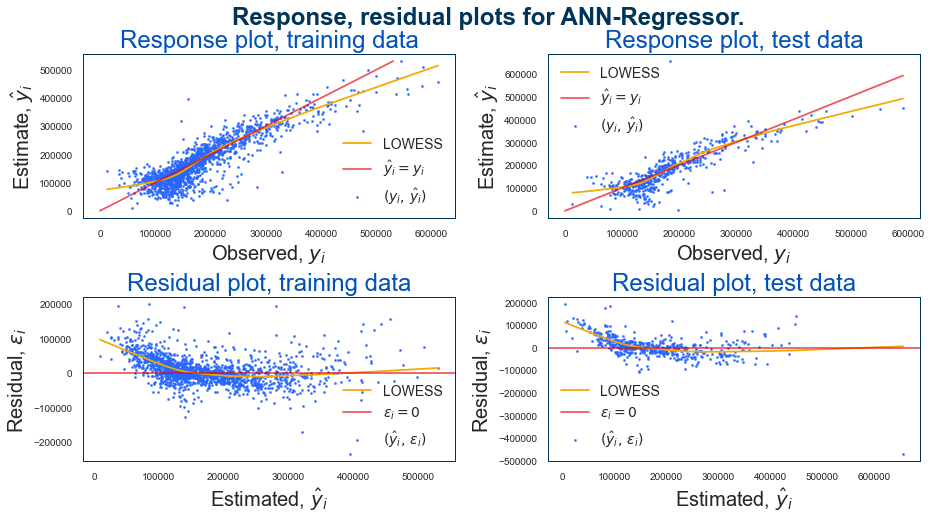

In [50]:
# Construct and grid-search an ANN regressor.
def model_func(layer_one_neurons = 32,
               layer_two_neurons = 32):
    model = Sequential()
    model.add(Dense(units = layer_one_neurons,
                    activation = 'relu',
                    input_shape = (177,)))
    model.add(Dense(units = layer_two_neurons,
                    activation = 'relu'))
    model.add(Dense(units = 1,
                    activation = 'linear'))
    model.compile(loss = 'mse',
                  optimizer = 'adam')
    return model

ann = KerasRegressor(build_fn = model_func,
                     verbose = 0)
param_grid = {'epochs' : [20],
              'layer_one_neurons' : range(200,400,20),
              'layer_two_neurons' : range(200,400,20)}

annGs = GridSearchCV(estimator = ann,
                     param_grid = param_grid,
                     cv = 5,
                     refit = True,
                     verbose = 1,
                     n_jobs = 10)

annGs.fit(X = sac_model_tts.get('X_train_scaled'),
          y = sac_model_tts.get('y_train'))


print('Train 𝘙² : {}\nTest 𝘙² : {}'
      .format(annGs.best_score_,
              annGs.score(X = sac_model_tts.get('X_test_scaled'),
                          y = sac_model_tts.get('y_test'))))
response_residual_plots(y_test = sac_model_tts.get('y_test'), 
                        y_train = sac_model_tts.get('y_train'), 
                        fit_test = annGs.predict(X = sac_model_tts.get('X_test_scaled') ), 
                        fit_train = annGs.predict(X = sac_model_tts.get('X_train_scaled') ), 
                        plot_title = 'Response, residual plots for ANN-Regressor.')



annGs.best_params_

In [51]:
ames_house_anova.update(
    {'ANN Regressor' : {'Train' : anova(y_observed = sac_model_tts.get('y_train'), 
                                        y_estimated = annGs.predict(X = sac_model_tts.get('X_train_scaled') )),
                       'Test' : anova(y_observed = sac_model_tts.get('y_test'), 
                                      y_estimated = annGs.predict(X = sac_model_tts.get('X_test_scaled') ))}})


ames_house_anova

{'Regresion Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 982984.2719206946,
   'root_SSR': 2951907.8368510236,
   'SST-SSE-SSR': 0.0,
   'R2': 0.9001801356955166},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 756536.9555734164,
   'root_SSR': 1783418.1135097453,
   'SST-SSE-SSR': -554980484474.9487,
   'R2': 0.8210264230987148}},
 'Ada-Boost Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 908835.225188148,
   'root_SSR': 2886098.1714201504,
   'SST-SSE-SSR': 524473834488.4199,
   'R2': 0.9146714943827372},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 738574.624236565,
   'root_SSR': 1648636.6875244286,
   'SST-SSE-SSR': -65547554749.69922,
   'R2': 0.829424211573175}},
 'Bagging-Tree Regressor': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 682044.7994894241,
   'root_SSR': 2821283.610548414,
   'SST-SSE-SSR': 1255191636446.2861,
   'R2': 0.9519437762801731},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 6

In [52]:
# ames_svr_gs = GridSearchCV(estimator = SVR(gamma = 'scale'),
#                           param_grid = {'C' : np.logspace(start = 5,
#                                                           stop = 10,
#                                                           num = 7),
#                                         'epsilon' : np.logspace(start = -3.0,
#                                                                 stop = -1.5,
#                                                                 num = 5)},
#                           refit = True,
#                           cv = 5,
#                           n_jobs = 10,
#                           verbose = True)
# ames_svr_gs.fit(X = sac_model_tts.get('X_train'),
#                 y = sac_model_tts.get('y_train'))
# print('Train 𝘙² : {}\nTest 𝘙² : {}'
#       .format(ames_svr_gs.best_score_,
#               ames_svr_gs.score(X = sac_model_tts.get('X_test'),
#                                 y = sac_model_tts.get('y_test'))))
# response_residual_plots(y_test = sac_model_tts.get('y_test'), 
#                         y_train = sac_model_tts.get('y_train'), 
#                         fit_test = ames_svr_gs.predict(X = sac_model_tts.get('X_test') ), 
#                         fit_train = ames_svr_gs.predict(X = sac_model_tts.get('X_train') ), 
#                         plot_title = 'Response, residual plots for Support-Vector Regressor.')
# ames_svr_gs.best_params_




In [53]:
# We now want to polynomialize our numeric and discrete variables. We then scale them.
#
# In our model iteration, we iteratively remove features. Our model's performance
# turns out to be outlier-drive.   We remove "outlier_driver" varibales that
# do not appear to phenomenologically explain sales price.  These are collected
# in a list of "outlier_drivers".
outlier_drivers = ['GrLivArea OverallQual', 'TotalBsmtSF', 'TotalBsmtSF OverallQual',
                   'TotalBsmtSF YearRemodAdd', 'TotalBsmtSF YearBuilt', 'GarageArea TotalBsmtSF',
                   'TotalBsmtSF FullBath', 'TotalBsmtSF Fireplaces', 'TotalBsmtSF GarageCars',
                   'GrLivArea TotalBsmtSF', 'TotalBsmtSF TotRmsAbvGrd', 'GrLivArea TotalBsmtSF',
                   'TotalBsmtSF TotRmsAbvGrd', 'TotalBsmtSF^2', 'GrLivArea YearRemodAdd', 'GrLivArea YearBuilt',
                   'GarageArea GrLivArea', 'GrLivArea FullBath', # 'GrLivArea^2', 
                   'GrLivArea Fireplaces', 'GarageArea OverallQual', 'GrLivArea TotRmsAbvGrd',
                   'GrLivArea GarageCars', 'Fireplaces OverallQual', 'GarageArea Fireplaces', 'GarageArea MasVnrArea',
                   'OverallQual^2', 'MasVnrArea OverallQual', 'GarageArea^2', 'OverallQual TotRmsAbvGrd']

numeric_poly = PolynomialFeatures(degree = 2,
                                  interaction_only = False,
                                  include_bias = False)
sac_house_model_mtx1 =\
pd.merge(right = pd.DataFrame(data = numeric_poly.fit_transform(sac_house_model_mtx0[influental_continuous +\
                                                                                     influental_discretes]),
                             columns = numeric_poly.get_feature_names(influental_continuous +\
                                                                      influental_discretes),
                             index = sac_house_model_mtx0.index),
         left = sac_house_model_mtx0.drop(labels = influental_continuous +\
                                                   influental_discretes,
                                          axis = 1),
         left_index = True,
         right_index = True).drop(labels = outlier_drivers,
                                  axis = 1)

sac_house_model_ttl_init = dict(zip(['X_train', 'X_test', 'y_train', 'y_test'],
                                       train_test_split(sac_house_model_mtx1.drop(labels = 'SalePrice',
                                                                                 axis = 1),
                                                        sac_house_model_mtx1['SalePrice'],
                                                        test_size = 0.25,
                                                        random_state = 123)))

sac_house_scaler = StandardScaler()
sac_house_scaler.fit(sac_house_model_ttl_init.get('X_train'))

sac_house_model_ttl_init.update(
    {'X_train_scaled' : pd.DataFrame(data = sac_house_scaler.transform(sac_house_model_ttl_init.get('X_train')),
                                    columns = sac_house_model_ttl_init.get('X_train').columns,
                                    index = sac_house_model_ttl_init.get('X_train').index).rename_axis(columns = 'attribute'),
     'X_test_scaled' : pd.DataFrame(data = sac_house_scaler.transform(sac_house_model_ttl_init.get('X_test')),
                                    columns = sac_house_model_ttl_init.get('X_test').columns,
                                    index = sac_house_model_ttl_init.get('X_test').index).rename_axis(columns = 'attribute')})




<font color = '#0051ba'>

## 🅔 **Model Development**.  

## 🅕 **Model Iteration**.  


    
</font>

In [54]:
sac_house_ridge_cv = RidgeCV(alphas = np.logspace(start = 1,
                                                 stop = 2.5,
                                                 num = 100),
                            scoring = 'r2',
                            cv = 5)
sac_house_ridge_cv.fit(X = sac_house_model_ttl_init.get('X_train_scaled'),
                       y = sac_house_model_ttl_init.get('y_train'))

RidgeCV(alphas=array([ 10.        ,  10.35503366,  10.72267222,  11.10336318,
        11.49756995,  11.90577239,  12.32846739,  12.76616949,
        13.21941148,  13.6887451 ,  14.17474163,  14.67799268,
        15.19911083,  15.73873043,  16.29750835,  16.87612476,
        17.475284  ,  18.09571541,  18.73817423,  19.4034425 ,
        20.09233003,  20.80567538,  21.5443469 ,  22.30924374,
        23.101297  ,  23.92147081,  24.77076356,  25.65020906,
        26.5608...
       141.74741629, 146.77992676, 151.9911083 , 157.38730432,
       162.97508346, 168.76124758, 174.75284   , 180.95715412,
       187.38174229, 194.03442496, 200.92330026, 208.05675382,
       215.443469  , 223.09243744, 231.01297001, 239.21470815,
       247.7076356 , 256.50209057, 265.60877829, 275.03878409,
       284.80358684, 294.91507296, 305.38555088, 316.22776602]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [55]:

α_ridge = sac_house_ridge_cv.alpha_
train_R2 = sac_house_ridge_cv.score(X = sac_house_model_ttl_init.get('X_train_scaled'),
                                   y = sac_house_model_ttl_init.get('y_train'))
test_R2 = sac_house_ridge_cv.score(X = sac_house_model_ttl_init.get('X_test_scaled'),
                                   y = sac_house_model_ttl_init.get('y_test'))



In [56]:

sac_house_model_ttl_init.update(
    {'fit_train_ridge' : pd.Series(data = sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_train_scaled')),
                                   index = sac_house_model_ttl_init.get('X_train_scaled').index),
     'fit_test_ridge' : pd.Series(data = sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_test_scaled')),
                                                                    index = sac_house_model_ttl_init.get('X_test_scaled').index)})



In [57]:
sac_house_model_ttl_init.update(
    {'resid_train_ridge' : sac_house_model_ttl_init.get('y_train').subtract(sac_house_model_ttl_init.get('fit_train_ridge')),
     'resid_test_ridge' : sac_house_model_ttl_init.get('y_test').subtract(sac_house_model_ttl_init.get('fit_test_ridge'))})

print('optimum ridge α = {} \nTrain R²: {} \nTest R²: {} \nTrain √SSE: {} \nTest √SSE: {}'\
      .format(α_ridge, 
              train_R2, 
              test_R2, 
              np.sqrt(np.sum(np.square(sac_house_model_ttl_init.get('resid_train_ridge')))),
              np.sqrt(np.sum(np.square(sac_house_model_ttl_init.get('resid_test_ridge'))))  ))



optimum ridge α = 316.22776601683796 
Train R²: 0.8909656456282677 
Test R²: 0.8107060135180686 
Train √SSE: 1062590.684740918 
Test √SSE: 683495.7808904737


In [58]:
ames_house_anova.update(
    {'Ridge Regression' : {'Train' : anova(y_observed = sac_model_tts.get('y_train'), 
                                        y_estimated = sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_train_scaled'))),
                       'Test' : anova(y_observed = sac_model_tts.get('y_test'), 
                                    y_estimated = sac_house_ridge_cv.predict(X = sac_house_model_ttl_init.get('X_test_scaled')))}})

ames_house_anova

{'Regresion Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 982984.2719206946,
   'root_SSR': 2951907.8368510236,
   'SST-SSE-SSR': 0.0,
   'R2': 0.9001801356955166},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 756536.9555734164,
   'root_SSR': 1783418.1135097453,
   'SST-SSE-SSR': -554980484474.9487,
   'R2': 0.8210264230987148}},
 'Ada-Boost Tree': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 908835.225188148,
   'root_SSR': 2886098.1714201504,
   'SST-SSE-SSR': 524473834488.4199,
   'R2': 0.9146714943827372},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 738574.624236565,
   'root_SSR': 1648636.6875244286,
   'SST-SSE-SSR': -65547554749.69922,
   'R2': 0.829424211573175}},
 'Bagging-Tree Regressor': {'Train': {'root_SST': 3111272.722874989,
   'root_SSE': 682044.7994894241,
   'root_SSR': 2821283.610548414,
   'SST-SSE-SSR': 1255191636446.2861,
   'R2': 0.9519437762801731},
  'Test': {'root_SST': 1788280.696162659,
   'root_SSE': 6

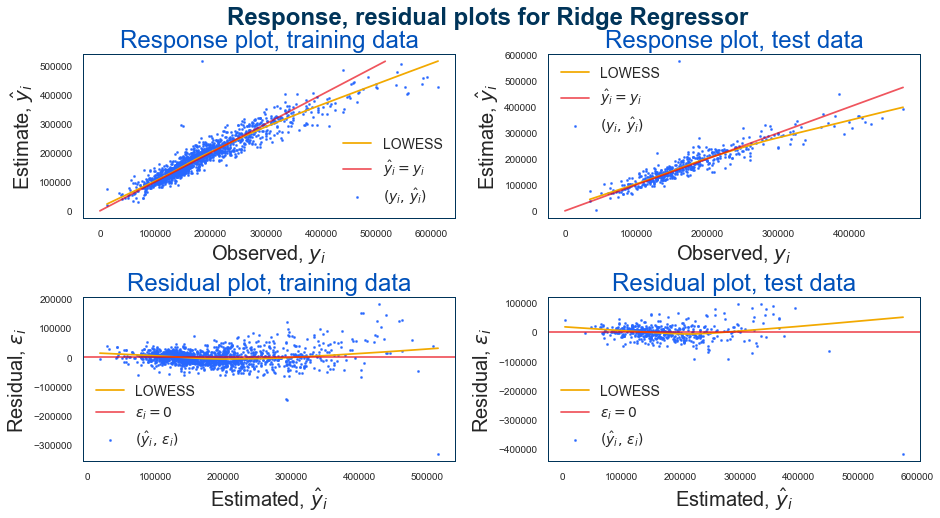

In [62]:
response_residual_plots(y_test = sac_house_model_ttl_init.get('y_test'),
                        y_train = sac_house_model_ttl_init.get('y_train'), 
                        fit_test = sac_house_model_ttl_init.get('fit_test_ridge'), 
                        fit_train = sac_house_model_ttl_init.get('fit_train_ridge'), 
                        plot_title = 'Response, residual plots for Ridge Regressor')
plt.savefig(os.path.join('./Graphics', 'Resp_resid_train_test.png'),
            dpi = 150,
            transparent = True,
            bbox_inches = 'tight')

<font color = '#0051ba'>
    

### Observation on *internal* statistical consistency between test and training data.
    
</font>

Figure 8 below represents an interesting digression related to statistical consistency. The figure — and accompanying Kolmogorov-Smirnov test statistics [NIST Engineering-Stats Handbook, §13.5.16](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm) — shows that test and training samples do not conform to the same statistical distributions.  The residual errors do, however.

This lies at the heart of statistical reasoning.  Very fundamentally,  "... statistics can be used to gain information about a population by examining a sample of the population; generalizations about a population from a sample are valid only if the sample is representative of that population.” [New York 6$^{th}$-grade mathematics learning standard 6.SP.1-b](http://www.nysed.gov/common/nysed/files/programs/curriculum-instruction/nys-next-generation-mathematics-p-12-standards.pdf)  In this case, the test and training data sets' distributions are not similar.  Setting aside overfitting issues, this diminishes our optimism about the ability of the model derived from training data to predict well the test data.

Now, our `sklearn.model_selection.train_test_split` function partitioned the training and test data from a common set.  There is no reason to suspect anything sinister, here.   Anecdotally, one can use a random generator — e.g, `scipy.stats.norm.rvs` — to produce 100$k^k$ realizations of a normal distribution.  One then conducts an experiment.  Draw a subset of that data without replacement, e.g.,  'numpy.random.choice', 10$^k$ times.  Then perform a two-way Kolmogorov-Smirnov test for the sample and the remaining sets.  Approximately eight percent of the time, K-S test tells us to reject the hypothesis that the two data sets are from the same probability distribution.  This perhaps is what is going on, here.

That the residuals do conform to the same distribution — given that the response variables — is *really* interesting.  This might be the result of mechanims related to the Central-Limit Theorem.  Specifically, regression model $$\hat{\boldsymbol{\mathrm{y}}} = \boldsymbol{\mathrm{X}} \, \big(\boldsymbol{\mathrm{X}}^T\boldsymbol{\mathrm{X}}  \big)^{-1}\,\boldsymbol{\mathrm{X}}^T\,\boldsymbol{\mathrm{y}} \text{.}$$  The operation represented by this takes all of the randomness in our explanatory and response variables and mixes them up.  All of this mixing might have the effect of nudging things in the direction of normality.

Now, the distributions of our residuals are clearly not normal.  They are not even homoskedistic.  But maybe they are "becoming normal."

In [ ]:
train_test_resid =\
pd.concat(objs = [pd.DataFrame(data = sac_house_model_ttl_init.get('resid_train_ridge'))\
                                            .rename(columns = {0 : 'Residual Error'})\
                                            .assign(data_set = 'train'),
                  pd.DataFrame(data = sac_house_model_ttl_init.get('resid_train_ridge'))\
                                            .rename(columns = {0 : 'Residual Error'})\
                                            .assign(data_set = 'test')],
          axis = 0)
train_test_resp =\
pd.concat(objs = [pd.DataFrame(data = sac_house_model_ttl_init.get('y_train'))\
                              .rename(columns = {0 : 'SalePrice'})\
                              .assign(data_set = 'train'),
                  pd.DataFrame(data = sac_house_model_ttl_init.get('y_test'))\
                              .assign(data_set = 'test')\
                              .rename(columns = {0 : 'SalePrice'})],
          axis = 0)

resid_2wy_ks = stats.ks_2samp(train_test_resid.set_index(keys = 'data_set')\
                                              .loc['train', 'Residual Error'],
                             train_test_resid.set_index(keys = 'data_set')\
                                              .loc['test', 'Residual Error']).pvalue
resp_2wy_ks = stats.ks_2samp(train_test_resp.set_index(keys = 'data_set')\
                                              .loc['train', 'SalePrice'],
                             train_test_resp.set_index(keys = 'data_set')\
                                              .loc['test', 'SalePrice']).pvalue
print('Residual K-S p-value {}\nResponse K-S p-value {}'.format(resid_2wy_ks, resp_2wy_ks))
fig, axes = plt.subplots(1,2, figsize = (15, 9))
sns.violinplot(x = train_test_resid['data_set'],
               y = train_test_resid['Residual Error'],
               ax = axes[1]);
sns.violinplot(x = train_test_resp['data_set'],
               y = train_test_resp['SalePrice'],
               ax = axes[0]);
axes[0].set_title(label = 'Response variables',
                  fontsize = 28,
                  color = '#0051ba')
axes[1].set_title(label = 'Residual errors',
                  fontsize = 28,
                  color = '#0051ba');
axes[0].set_xlabel(xlabel = 'data set',
                   fontsize = 24)
axes[1].set_xlabel(xlabel = 'data set',
                   fontsize = 24)
axes[0].set_ylabel(ylabel = 'Response variable, SalePrice',
                   fontsize = 24)
axes[1].set_ylabel(ylabel = 'Residual error, $\epsilon_i$',
                   fontsize = 24)
axes[0].tick_params(labelsize = 20,
                    axis = 'x')
axes[1].tick_params(labelsize = 20,
                    axis = 'x')
axes[0].text(s = '$H_0: \mathcal{D}_\mathrm{train} \sim \mathcal{D}_\mathrm{test}$\n$p=0.03$ ',
             x = 0.95,
             y = 575000,
             verticalalignment = 'bottom',
             horizontalalignment = 'right',
             fontsize = 24)
axes[1].text(s = '$H_0: \mathcal{D}_\mathrm{train} \sim \mathcal{D}_\mathrm{test}$\n$p=1.0$',
             x = 0.95,
             y = 150000,
             verticalalignment = 'bottom',
             horizontalalignment = 'right',
             fontsize = 24)

fig.subplots_adjust(wspace = 0.25)
plt.tight_layout()
plt.savefig(os.path.join('./Graphics', 'Resp_resid_distributions.png'),
            dpi = 150)

plt.suptitle(t = "Figure 8 — Interesting Observation:  The response\n" +\
                 "variables' training and test distributions do not coincide. \n" +\
                 "Those for the residuals do!\n" +\
                  "(As per Kolmogorov-Smirnov Test.)",
             va = 'bottom',
             y = 1.,
             color = '#003459',
             fontsize = 32);

<font color = '#0051ba'>

## 🅖 **Model Interpretation**.  


    
</font>

In [ ]:
test_outliers =\
sac_house_model_ttl_init.get('resid_test_ridge').abs()\
                                                .sort_values(ascending = False)\
                                                .head(n = 5)\
                                                .index
print(test_outliers)

test_outliers_data =\
pd.merge(left = pd.DataFrame(data = pd.Series(dict(zip(sac_house_model_ttl_init.get('X_test_scale').columns,
                                                          sac_house_ridge_cv.coef_))),
                            columns = ['β']).rename_axis(columns = 'attribute'),
         right = sac_house_model_ttl_init.get('X_test_scale').T[test_outliers],
         left_index = True,
         right_index = True)

test_outliers_data.rename(columns = dict(zip(test_outliers_data.columns,
                                               map(str, test_outliers_data.columns))),
                           inplace = True)

for id_key in map(str, test_outliers):
    test_outliers_data = test_outliers_data.assign(coef_explan = test_outliers_data['β'] * test_outliers_data[id_key])\
                                             .rename(columns = {'coef_explan' : str(id_key) + ', βᵢ×𝘹ᵢ'})
test_outliers_data =\
test_outliers_data.sort_index(axis = 1)\
                    .sort_values(by = [cols
                                        for cols in test_outliers_data.columns
                                        if str(test_outliers[0]) + ', β' in cols],
                                 ascending = False)
test_outliers_data.to_csv(path_or_buf = os.path.join('./datasets',
                                                      'test_resid_outliers.csv'))
print(list(test_outliers_data.index)[:10])
test_outliers_data

In [ ]:
train_outliers =\
sac_house_model_ttl_init.get('resid_train_ridge').abs()\
                                                .sort_values(ascending = False)\
                                                .head(n = 4)\
                                                .index
train_outliers

train_outliers_data =\
pd.merge(left = pd.DataFrame(data = pd.Series(dict(zip(sac_house_model_ttl_init.get('X_test_scale').columns,
                                                          sac_house_ridge_cv.coef_))),
                            columns = ['β']).rename_axis(columns = 'attribute'),
         right = sac_house_model_ttl_init.get('X_train_scale').T[train_outliers],
         left_index = True,
         right_index = True)

train_outliers_data.rename(columns = dict(zip(train_outliers_data.columns,
                                               map(str, train_outliers_data.columns))),
                           inplace = True)

for id_key in map(str, train_outliers):
    train_outliers_data = train_outliers_data.assign(coef_explan = train_outliers_data['β'] * train_outliers_data[id_key])\
                                             .rename(columns = {'coef_explan' : str(id_key) + ', βᵢ×𝘹ᵢ'})
train_outliers_data =\
train_outliers_data.sort_index(axis = 1)\
                    .sort_values(by = [cols
                                        for cols in train_outliers_data.columns
                                        if str(train_outliers[0]) + ', β' in cols],
                                 ascending = False)
train_outliers_data.to_csv(path_or_buf = os.path.join('./datasets',
                                                      'train_resid_outliers.csv'))
print(train_outliers)
print(list(train_outliers_data.index)[:5])
train_outliers_data

In [ ]:
# Look at the dimensionality of the explanatory-variable set.  We calculate the
# singluar-value spectrum.
explan_variable_sing_vals =\
np.linalg.svd(a = pd.concat(objs = [sac_house_model_ttl_init.get('X_train_scale'),
                                      sac_house_model_ttl_init.get('X_test_scale')]).to_numpy(),
              full_matrices = False,
              compute_uv = False)
plt.bar(x = range(len(explan_variable_sing_vals)),
        height = explan_variable_sing_vals,
        color = '#0051ba',
        edgecolor = '#003459')
plt.xlabel(xlabel = 'Singular-value index')
plt.ylabel(ylabel = 'Singular-value magnitude')
plt.yscale(value = 'log')
plt.ylim(bottom = 3 * 10**(-0),
         top = 300)
plt.xlim(left = -1,
         right = 145)
plt.title(label = 'Singular-value spectrum of\nexplanatory variables.',
          fontsize = 24,
          color = '#003459');

In [ ]:
np.sum(np.cumsum(explan_variable_sing_vals)/np.sum(explan_variable_sing_vals) <= 0.95)

In [ ]:
len(explan_variable_sing_vals)

In [ ]:
sac_house_lasso_cv = ElasticNetCV(alphas = np.logspace(start = 0.5,
                                                         stop = 1,
                                                         num = 100),
                                  cv = 5,
                                  l1_ratio = 0.5)
sac_house_lasso_cv.fit(X = sac_house_model_ttl_init.get('X_train_scale'),
                       y = sac_house_model_ttl_init.get('y_train'))
α_lasso = sac_house_lasso_cv.alpha_
train_R2 = sac_house_lasso_cv.score(X = sac_house_model_ttl_init.get('X_train_scale'),
                                   y = sac_house_model_ttl_init.get('y_train'))
test_R2 = sac_house_lasso_cv.score(X = sac_house_model_ttl_init.get('X_test_scale'),
                                   y = sac_house_model_ttl_init.get('y_test'))
print('optimum lasso α = {} \n Train R² : {} \n Test R² : {}'.format(α_lasso, train_R2, test_R2))
sac_house_model_ttl_init.update(
    {'fit_train_lasso' : sac_house_lasso_cv.predict(X = sac_house_model_ttl_init.get('X_train_scale')),
     'fit_test_lasso' : sac_house_lasso_cv.predict(X = sac_house_model_ttl_init.get('X_test_scale')),
     'fit_unseen_test_lasso' : pd.DataFrame(data = sac_house_lasso_cv.predict(X = sac_house_test_mtx1),
                                           index = sac_house_test_mtx1.index,
                                           columns = ['SalePrice'])})
sac_house_model_ttl_init.update(
    {'resid_train_lasso' : sac_house_model_ttl_init.get('y_train') - sac_house_model_ttl_init.get('fit_train_lasso'),
     'resid_test_lasso' : sac_house_model_ttl_init.get('y_test') - sac_house_model_ttl_init.get('fit_test_lasso')})

In [ ]:
sac_house_enet_cv = ElasticNetCV(alphas = np.logspace(start = 0.5,
                                                         stop = 1,
                                                         num = 100),
                                  cv = 5,
                                  l1_ratio = 0.85)
sac_house_enet_cv.fit(X = sac_house_model_ttl_init.get('X_train_scale'),
                       y = sac_house_model_ttl_init.get('y_train'))
α_elnet = sac_house_enet_cv.alpha_
train_R2 = sac_house_enet_cv.score(X = sac_house_model_ttl_init.get('X_train_scale'),
                                   y = sac_house_model_ttl_init.get('y_train'))
test_R2 = sac_house_enet_cv.score(X = sac_house_model_ttl_init.get('X_test_scale'),
                                   y = sac_house_model_ttl_init.get('y_test'))
print('optimum ElasticNet α = {} \n Train R² : {} \n Test R² : {}'.format(α_elnet, train_R2, test_R2))
sac_house_model_ttl_init.update(
    {'fit_train_elnet' : sac_house_enet_cv.predict(X = sac_house_model_ttl_init.get('X_train_scale')),
     'fit_test_elnet' : sac_house_enet_cv.predict(X = sac_house_model_ttl_init.get('X_test_scale')),
     'fit_unseen_test_elnet' : pd.DataFrame(data = sac_house_enet_cv.predict(X = sac_house_test_mtx1),
                                           index = sac_house_test_mtx1.index,
                                           columns = ['SalePrice'])})
sac_house_model_ttl_init.update(
    {'resid_train_elnet' : sac_house_model_ttl_init.get('y_train') - sac_house_model_ttl_init.get('fit_train_elnet'),
     'resid_test_elnet' : sac_house_model_ttl_init.get('y_test') - sac_house_model_ttl_init.get('fit_test_elnet')})

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 9))
resp_lowess = sm.nonparametric.lowess
resp_lowess_fit = resp_lowess(endog = sac_house_model_ttl_init.get('fit_train_ridge'),
                              exog = sac_house_model_ttl_init.get('y_train'))
axes[0].plot(resp_lowess_fit[:,0],
             resp_lowess_fit[:,1],
             color = '#f2a900',
             label = 'LOWESS')
axes[0].plot([0,min(max(sac_house_model_ttl_init.get('y_train')),
                    max(sac_house_model_ttl_init.get('fit_train_ridge')))],
             [0,min(max(sac_house_model_ttl_init.get('y_train')),
                    max(sac_house_model_ttl_init.get('fit_train_ridge')))],
             color = '#c66e4e',
             label = '$\hat{y}_i = y_i$')
axes[0].scatter(sac_house_model_ttl_init.get('y_train'),
                sac_house_model_ttl_init.get('fit_train_ridge'),
                color = '#2767ff',
                s = 3,
             label = '$ (y_i, \hat{y}_i)$')
axes[0].legend(loc = 'upper left',
               fontsize = 14)
axes[0].set_xlabel(xlabel = '$y_i$',
               fontsize = 14)
axes[0].set_ylabel(ylabel = '$\hat{y}_i$',
               fontsize = 14);
axes[0].set_title(label = 'Response Plot',
                  color = '#0051ba',
                  fontsize = 16)
axes[0].grid(True)


resid_lowess = sm.nonparametric.lowess
resid_lowess_fit = resp_lowess(exog = sac_house_model_ttl_init.get('fit_train_ridge'),
                              endog = sac_house_model_ttl_init.get('resid_train_ridge'))
axes[1].plot(resid_lowess_fit[:,0],
             resid_lowess_fit[:,1],
             color = '#f2a900',
             label = 'LOWESS')
axes[1].axhline(color = '#c66e4e',
                label = '$\epsilon_i = 0$')
axes[1].scatter(sac_house_model_ttl_init.get('fit_train_ridge'),
                sac_house_model_ttl_init.get('resid_train_ridge'),
                color = '#2767ff',
                s = 3,
             label = '$ (\hat{y}_i, \epsilon_i)$')
axes[1].legend(loc = 'lower left',
               fontsize = 14)
axes[1].set_xlabel(xlabel = '$\hat{y}_i$',
               fontsize = 14)
axes[1].set_ylabel(ylabel = '$\epsilon_i$',
               fontsize = 14);
axes[1].set_title(label = 'Residual Plot',
                  color = '#0051ba',
                  fontsize = 16)
fig.subplots_adjust(hspace = 0.275)

plt.savefig('Resp_resid.png',
        dpi = 150)